<a href="https://colab.research.google.com/github/mangaorphy/Formative2-Malaria-Diagnosis-CNN-Transfer-Learning-Group-5/blob/main/Malaria_Diagnosis_CNN_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

## Configuration

In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Importing Libraries

In [ ]:
# Import additional libraries for evaluation and visualization
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import json
import gc  # Garbage collection for memory management

In [ ]:
# Importing basic libraries
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Importing the Keras/TensorFlow libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

## Prepare DataSet

# Download the data for Malaria cells

In [ ]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 18:07:06--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.163.189.83, 3.163.189.81, 3.163.189.93, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.163.189.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   292MB/s    in 1.2s    

2025-10-05 18:07:07 (292 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


# Define the useful paths for data accessibility

In [ ]:
# Define the useful paths for data accessibility (updated for local environment)
base_dir = '/content/cell_images'
parasitized_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

# Create directories for train/validation/test splits
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Base directory: {base_dir}")
print(f"Parasitized images directory: {parasitized_dir}")
print(f"Uninfected images directory: {uninfected_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

# Verify data directories exist
print(f"\nParasitized folder exists: {os.path.exists(parasitized_dir)}")
print(f"Uninfected folder exists: {os.path.exists(uninfected_dir)}")

Base directory: /content/cell_images
Parasitized images directory: /content/cell_images/Parasitized
Uninfected images directory: /content/cell_images/Uninfected
Training directory: /content/cell_images/train
Validation directory: /content/cell_images/validation
Test directory: /content/cell_images/test

Parasitized folder exists: True
Uninfected folder exists: True


# Data Exploration: Check dataset statistics

In [ ]:
# Data Exploration: Check dataset statistics
print("=== DATASET EXPLORATION ===")

# Count images in each directory
parasitized_files = os.listdir(parasitized_dir)
uninfected_files = os.listdir(uninfected_dir)

# Filter only image files
parasitized_files = [f for f in parasitized_files if f.endswith(('.png', '.jpg', '.jpeg'))]
uninfected_files = [f for f in uninfected_files if f.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total Parasitized images: {len(parasitized_files)}")
print(f"Total Uninfected images: {len(uninfected_files)}")
print(f"Total images: {len(parasitized_files) + len(uninfected_files)}")
print(f"Dataset is balanced: {len(parasitized_files) == len(uninfected_files)}")

=== DATASET EXPLORATION ===
Total Parasitized images: 13779
Total Uninfected images: 13779
Total images: 27558
Dataset is balanced: True



=== PARASITIZED IMAGES ANALYSIS ===


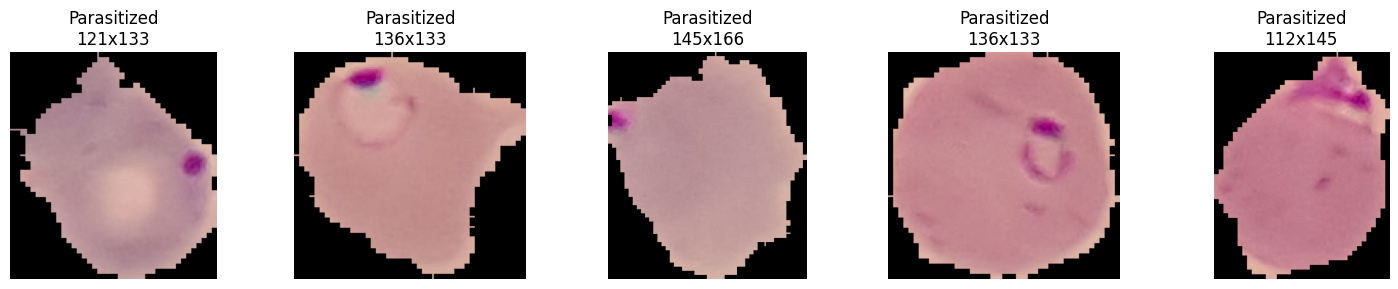

Sample sizes (W x H): [(121, 133), (136, 133), (145, 166), (136, 133), (112, 145)]
Width range: 112 - 145
Height range: 133 - 166

=== UNINFECTED IMAGES ANALYSIS ===


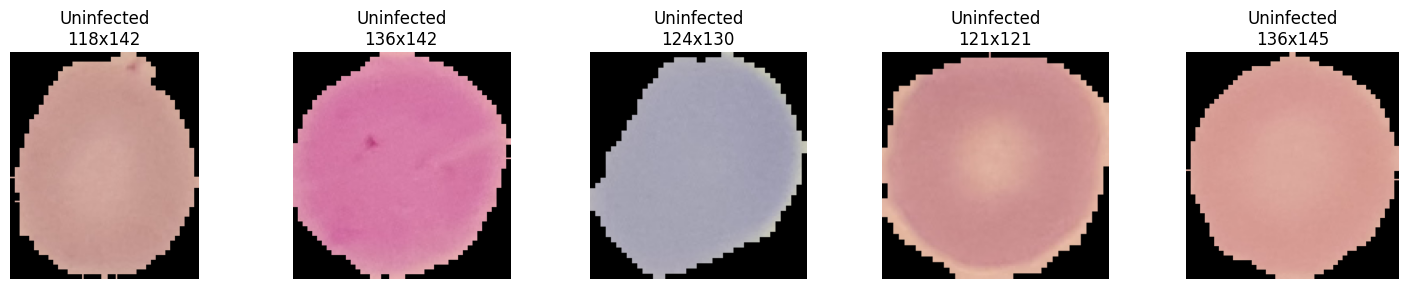

Sample sizes (W x H): [(118, 142), (136, 142), (124, 130), (121, 121), (136, 145)]
Width range: 118 - 136
Height range: 121 - 145


In [ ]:
import shutil

# Analyze image properties and display sample images
def analyze_images(directory, class_name, num_samples=5):
    """Analyze image properties and display samples"""
    print(f"\n=== {class_name.upper()} IMAGES ANALYSIS ===")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    sizes = []

    plt.figure(figsize=(15, 3))

    for i, filename in enumerate(files):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        sizes.append(img.size)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{img.size[0]}x{img.size[1]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print size statistics
    widths = [size[0] for size in sizes]
    heights = [size[1] for size in sizes]

    print(f"Sample sizes (W x H): {sizes}")
    print(f"Width range: {min(widths)} - {max(widths)}")
    print(f"Height range: {min(heights)} - {max(heights)}")

    return sizes

# Analyze both classes
parasitized_sizes = analyze_images(parasitized_dir, "Parasitized")
uninfected_sizes = analyze_images(uninfected_dir, "Uninfected")

# Comprehensive image size analysis

Analyzing image dimensions across dataset...

Analyzing all Parasitized image sizes...


Processing Parasitized: 100%|██████████| 1000/1000 [00:00<00:00, 20151.65it/s]



Analyzing all Uninfected image sizes...


Processing Uninfected: 100%|██████████| 1000/1000 [00:00<00:00, 20861.99it/s]


=== IMAGE SIZE STATISTICS ===
Total images analyzed: 2000
Width  - Min: 61, Max: 238, Mean: 131.8
Height - Min: 61, Max: 235, Mean: 133.0


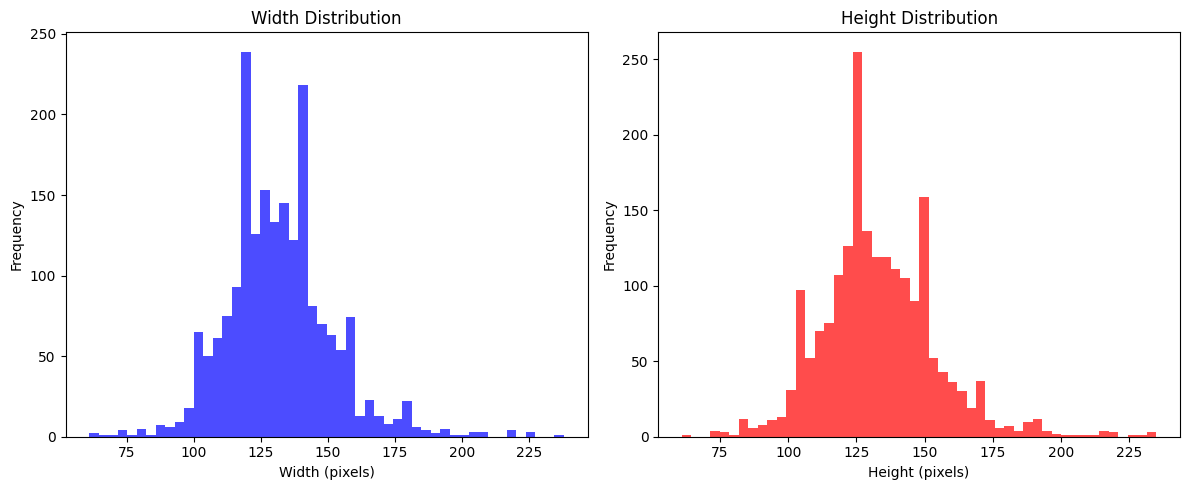

In [ ]:
# Comprehensive image size analysis
def get_all_image_sizes(directory, class_name):
    """Get sizes of all images in directory"""
    print(f"\nAnalyzing all {class_name} image sizes...")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sizes = []

    for filename in tqdm(files[:1000], desc=f"Processing {class_name}"): # Sample first 1000 for speed
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            sizes.append((img.size[0], img.size[1]))  # (width, height)
            img.close()
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    return sizes

# Analyze image sizes
print("Analyzing image dimensions across dataset...")
parasitized_all_sizes = get_all_image_sizes(parasitized_dir, "Parasitized")
uninfected_all_sizes = get_all_image_sizes(uninfected_dir, "Uninfected")

# Combine and analyze
all_sizes = parasitized_all_sizes + uninfected_all_sizes
widths = [size[0] for size in all_sizes]
heights = [size[1] for size in all_sizes]

print(f"\n=== IMAGE SIZE STATISTICS ===")
print(f"Total images analyzed: {len(all_sizes)}")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")

# Plot size distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, alpha=0.7, color='blue')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, alpha=0.7, color='red')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Configuration for data preprocessing

## Data Splitting and Directory Setup

In this section, we will define the parameters for splitting the dataset into training, validation, and testing sets. We will also create the necessary directory structure to organize the images for each split.

This cell defines the key parameters used for preparing the image data for the deep learning model:

- `IMG_SIZE`: This sets the target size (width and height) to which all images will be resized. Standardizing image size is essential for feeding data into a convolutional neural network.
- `BATCH_SIZE`: This determines the number of samples that will be processed in each training step. Larger batch sizes can sometimes lead to faster training but may require more memory.
- `TRAIN_SPLIT`, `VAL_SPLIT`, `TEST_SPLIT`: These define the proportions of the dataset that will be allocated to the training, validation, and testing sets, respectively. A common split is 70% for training, 15% for validation, and 15% for testing, as used here.

The code also calls a function `create_directories` to set up the necessary folder structure within the `cell_images` directory to hold the images for each split (train, validation, and test) and their respective classes (Parasitized and Uninfected). This organization is crucial for using data generators effectively.

In [ ]:
# Configuration for data preprocessing
IMG_SIZE = 64  # Standard size for malaria cell images
BATCH_SIZE = 32
TRAIN_SPLIT = 0.7  # 70% for training
VAL_SPLIT = 0.15   # 15% for validation
TEST_SPLIT = 0.15  # 15% for testing

print(f"Image target size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Data splits - Train: {TRAIN_SPLIT*100}%, Val: {VAL_SPLIT*100}%, Test: {TEST_SPLIT*100}%")

# Create directories if they don't exist
def create_directories():
    dirs_to_create = [
        train_dir, val_dir, test_dir,
        os.path.join(train_dir, 'Parasitized'),
        os.path.join(train_dir, 'Uninfected'),
        os.path.join(val_dir, 'Parasitized'),
        os.path.join(val_dir, 'Uninfected'),
        os.path.join(test_dir, 'Parasitized'),
        os.path.join(test_dir, 'Uninfected')
    ]

    for directory in dirs_to_create:
        os.makedirs(directory, exist_ok=True)
        print(f"Created/verified directory: {directory}")

create_directories()

Image target size: 64x64
Batch size: 32
Data splits - Train: 70.0%, Val: 15.0%, Test: 15.0%
Created/verified directory: /content/cell_images/train
Created/verified directory: /content/cell_images/validation
Created/verified directory: /content/cell_images/test
Created/verified directory: /content/cell_images/train/Parasitized
Created/verified directory: /content/cell_images/train/Uninfected
Created/verified directory: /content/cell_images/validation/Parasitized
Created/verified directory: /content/cell_images/validation/Uninfected
Created/verified directory: /content/cell_images/test/Parasitized
Created/verified directory: /content/cell_images/test/Uninfected


## Split data into train/validation/test

In [ ]:
# Function to split data into train/validation/test sets
def split_and_copy_data():
    """Split data and copy to respective directories"""

    # Get all image files for each class
    parasitized_files = [f for f in os.listdir(parasitized_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_files = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Splitting {len(parasitized_files)} parasitized images...")
    print(f"Splitting {len(uninfected_files)} uninfected images...")

    # Shuffle the files
    parasitized_files = shuffle(parasitized_files, random_state=42)
    uninfected_files = shuffle(uninfected_files, random_state=42)

    def split_files(files, class_name):
        """Split files for a single class"""
        n_total = len(files)
        n_train = int(n_total * TRAIN_SPLIT)
        n_val = int(n_total * VAL_SPLIT)

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        print(f"{class_name} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

        return train_files, val_files, test_files

    # Split files for each class
    para_train, para_val, para_test = split_files(parasitized_files, "Parasitized")
    uninf_train, uninf_val, uninf_test = split_files(uninfected_files, "Uninfected")

    # Copy files to respective directories
    def copy_files(file_list, source_dir, dest_dir, class_name, split_name):
        """Copy files from source to destination"""
        dest_class_dir = os.path.join(dest_dir, class_name)

        for filename in tqdm(file_list, desc=f"Copying {class_name} {split_name}"):
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_class_dir, filename)

            # Only copy if destination doesn't exist
            if not os.path.exists(dst_path):
                shutil.copy2(src_path, dst_path)

    # Copy all files
    copy_files(para_train, parasitized_dir, train_dir, 'Parasitized', 'train')
    copy_files(para_val, parasitized_dir, val_dir, 'Parasitized', 'val')
    copy_files(para_test, parasitized_dir, test_dir, 'Parasitized', 'test')

    copy_files(uninf_train, uninfected_dir, train_dir, 'Uninfected', 'train')
    copy_files(uninf_val, uninfected_dir, val_dir, 'Uninfected', 'val')
    copy_files(uninf_test, uninfected_dir, test_dir, 'Uninfected', 'test')

    print("Data splitting complete!")

    return {
        'train': {'parasitized': len(para_train), 'uninfected': len(uninf_train)},
        'val': {'parasitized': len(para_val), 'uninfected': len(uninf_val)},
        'test': {'parasitized': len(para_test), 'uninfected': len(uninf_test)}
    }

# Execute the splitting (only if directories are empty)
train_para_dir = os.path.join(train_dir, 'Parasitized')
if len(os.listdir(train_para_dir)) == 0:
    print("Performing data split...")
    split_stats = split_and_copy_data()
    print(f"\nFinal split statistics: {split_stats}")
else:
    print("Data already split, skipping...")

Performing data split...
Splitting 13779 parasitized images...
Splitting 13779 uninfected images...
Parasitized split: 9645 train, 2066 val, 2068 test
Uninfected split: 9645 train, 2066 val, 2068 test


Copying Uninfected test: 100%|██████████| 2068/2068 [00:00<00:00, 7514.04it/s]

Data splitting complete!

Final split statistics: {'train': {'parasitized': 9645, 'uninfected': 9645}, 'val': {'parasitized': 2066, 'uninfected': 2066}, 'test': {'parasitized': 2068, 'uninfected': 2068}}


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


# Define the image preprocessing function for tf.data pipeline for Baseline CNN Model

In [ ]:
# Define the image preprocessing function for tf.data pipeline
def load_image_and_label(file_path, label):
    """Load and preprocess an image file with its label"""
    # Read the image file
    image = tf.io.read_file(file_path)

    # Decode as JPEG (most malaria images are JPEG format)
    image = tf.image.decode_jpeg(image, channels=3)

    # Set the shape explicitly (this is important for tf.data pipeline)
    image.set_shape([None, None, 3])

    # Resize to target size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # Convert to float and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert label to float32
    label = tf.cast(label, tf.float32)

    return image, label

print("✓ Image preprocessing function defined")

✓ Image preprocessing function defined


## Baseline CNN model architecture - Withe 3 Convolutional Layers and a Dense Layer

In [ ]:
# Define the baseline CNN model architecture
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization()) # Add Batch Normalization

# Convolutional Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization()) # Add Batch Normalization

# Convolutional Layer 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization()) # Add Batch Normalization

# Flatten the output from the convolutional layers
model.add(Flatten())

# Dense Layer 1
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5)) # Add Dropout for regularization

# Output Layer
model.add(Dense(units=1, activation='sigmoid')) # Using sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,225 (2.61 MB)

 Trainable params: 683,777 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Prepare data with `tf.data`

Create `tf.data` datasets for training, validation, and testing, including mapping for image loading and resizing, shuffling, and prefetching.


In [ ]:
# 2. Create lists of file paths and labels (re-running this section to fix the error)
def create_file_list_and_labels(directory, label):
    """Creates lists of file paths and labels for a given directory and label."""
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    labels = [label] * len(file_paths)
    return file_paths, labels

# Get file paths and labels for each class and split
parasitized_train_files, parasitized_train_labels = create_file_list_and_labels(os.path.join(train_dir, 'Parasitized'), 1)
uninfected_train_files, uninfected_train_labels = create_file_list_and_labels(os.path.join(train_dir, 'Uninfected'), 0)

parasitized_val_files, parasitized_val_labels = create_file_list_and_labels(os.path.join(val_dir, 'Parasitized'), 1)
uninfected_val_files, uninfected_val_labels = create_file_list_and_labels(os.path.join(val_dir, 'Uninfected'), 0)

parasitized_test_files, parasitized_test_labels = create_file_list_and_labels(os.path.join(test_dir, 'Parasitized'), 1)
uninfected_test_files, uninfected_test_labels = create_file_list_and_labels(os.path.join(test_dir, 'Uninfected'), 0)

# Combine file paths and labels for each split (Corrected concatenation for val_files and test_files)
train_files = parasitized_train_files + uninfected_train_files
train_labels = parasitized_train_labels + uninfected_train_labels

val_files = parasitized_val_files + uninfected_val_files
val_labels = parasitized_val_labels + uninfected_val_labels

test_files = parasitized_test_files + uninfected_test_files
test_labels = parasitized_test_labels + uninfected_test_labels

# 3. Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))

# 4. Map the loading and preprocessing function
train_dataset = train_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

# 5. Shuffle the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_files))

# 6. Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# 7. Apply prefetching
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("tf.data datasets created and preprocessed successfully.")
print(f"Train dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")
print(f"Test dataset: {test_dataset}")

tf.data datasets created and preprocessed successfully.
Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


##Train the model

Train the baseline CNN model using the `tf.data` datasets.


In [ ]:
# 1. Define the number of training epochs.
EPOCHS = 15

# 2. Train the model using the .fit() method
# 3. Store the training history in a variable
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.7171 - loss: 0.6114 - val_accuracy: 0.8909 - val_loss: 0.3054
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9387 - loss: 0.1926 - val_accuracy: 0.9451 - val_loss: 0.1719
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9480 - loss: 0.1654 - val_accuracy: 0.9497 - val_loss: 0.1532
Epoch 4/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9521 - loss: 0.1434 - val_accuracy: 0.9506 - val_loss: 0.1615
Epoch 5/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9534 - loss: 0.1374 - val_accuracy: 0.9572 - val_loss: 0.1469
Epoch 6/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9611 - loss: 0.1205 - val_accuracy: 0.9526 - val_loss: 0.1349
Epoch 7/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9611 - loss: 0.1195 - val_accuracy: 0.9576 - val_loss: 0.1335
Epoch 8/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9661 - loss: 0.1034 - va

In [ ]:
# Evaluation functions for comprehensive analysis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_model_comprehensive(model, test_dataset, model_name="Model"):
    """
    Comprehensive model evaluation with metrics and visualizations
    """
    print(f"\n{'='*60}")
    print(f"🔍 EVALUATING {model_name.upper()}")
    print(f"{'='*60}")

    # Get predictions
    print("Generating predictions...")
    y_true = []
    y_pred_proba = []

    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred_proba.extend(predictions.flatten())

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    print(f"   Test Loss: {test_loss:.4f}")

    # Classification report
    print(f"\n CLASSIFICATION REPORT:")
    class_names = ['Uninfected', 'Parasitized']
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Training History (if available)
    if 'history' in globals() and history is not None:
        ax1 = axes[0]
        ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax1.set_title(f'{model_name} - Training History', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'Training History\nNot Available',
                    ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
        axes[0].set_title(f'{model_name} - Training History', fontweight='bold')

    # 2. Confusion Matrix
    ax2 = axes[1]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=class_names, yticklabels=class_names)
    ax2.set_title(f'{model_name} - Confusion Matrix', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    # 3. ROC Curve
    ax3 = axes[2]
    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title(f'{model_name} - ROC Curve', fontweight='bold', fontsize=12)
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return metrics for comparison
    return {
        'model_name': model_name,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print(" Evaluation functions defined")

 Evaluation functions defined


## Evaluate Baseline CNN Model

Now let's evaluate the trained baseline model and visualize the results with:
- **Training History** - Learning curves showing accuracy/loss over epochs
- **Confusion Matrix** - Visual breakdown of correct/incorrect predictions
- **ROC Curve** - Performance metric with AUC score
- **Detailed Metrics** - Precision, Recall, F1-Score for each class


🔍 EVALUATING BASELINE CNN
Generating predictions...

📊 PERFORMANCE METRICS:
   Test Accuracy: 0.9345
   Test Loss: 0.2039

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Uninfected     0.8984    0.9797    0.9373      2068
 Parasitized     0.9777    0.8893    0.9314      2068

    accuracy                         0.9345      4136
   macro avg     0.9381    0.9345    0.9343      4136
weighted avg     0.9381    0.9345    0.9343      4136



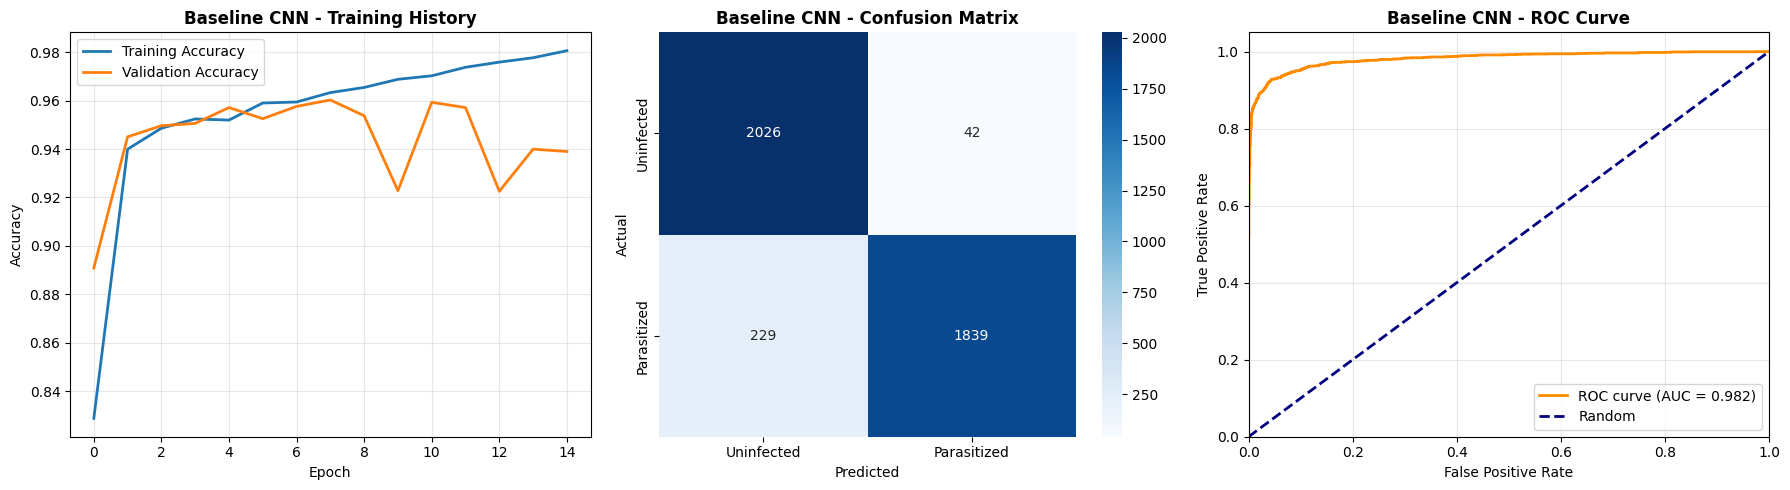


📈 BASELINE CNN EVALUATION COMPLETE!

🎯 Key Metrics:
   • Test Accuracy:  0.9345 (93.45%)
   • Test Loss:      0.2039
   • ROC-AUC Score:  0.9815

📊 Confusion Matrix Breakdown:
   True Negatives (Uninfected correctly classified):  2,026
   True Positives (Parasitized correctly classified): 1,839
   False Positives (Uninfected misclassified):        42
   False Negatives (Parasitized misclassified):       229

🏥 Clinical Metrics:
   Sensitivity (True Positive Rate):  0.8893 (88.93%)
   Specificity (True Negative Rate):  0.9797 (97.97%)

💡 INTERPRETATION:
   ✅ GOOD performance! Your model achieves >90% accuracy.

📸 The graphs above show:
   1. Training History - How accuracy improved during training
   2. Confusion Matrix - Detailed breakdown of predictions
   3. ROC Curve - Overall model discrimination ability


In [ ]:
# Evaluate the Baseline CNN model and display comprehensive visualizations
baseline_results = evaluate_model_comprehensive(model, test_dataset, model_name="Baseline CNN")

print("\n" + "="*80)
print("📈 BASELINE CNN EVALUATION COMPLETE!")
print("="*80)
print(f"\n🎯 Key Metrics:")
print(f"   • Test Accuracy:  {baseline_results['test_accuracy']:.4f} ({baseline_results['test_accuracy']*100:.2f}%)")
print(f"   • Test Loss:      {baseline_results['test_loss']:.4f}")
print(f"   • ROC-AUC Score:  {baseline_results['roc_auc']:.4f}")

print(f"\n📊 Confusion Matrix Breakdown:")
cm = baseline_results['confusion_matrix']
tn, fp, fn, tp = cm.ravel()
print(f"   True Negatives (Uninfected correctly classified):  {tn:,}")
print(f"   True Positives (Parasitized correctly classified): {tp:,}")
print(f"   False Positives (Uninfected misclassified):        {fp:,}")
print(f"   False Negatives (Parasitized misclassified):       {fn:,}")

# Calculate additional metrics
sensitivity = tp / (tp + fn)  # Recall for Parasitized
specificity = tn / (tn + fp)  # Recall for Uninfected

print(f"\n🏥 Clinical Metrics:")
print(f"   Sensitivity (True Positive Rate):  {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity (True Negative Rate):  {specificity:.4f} ({specificity*100:.2f}%)")

print("\n💡 INTERPRETATION:")
if baseline_results['test_accuracy'] >= 0.95:
    print("   ✅ EXCELLENT performance! Your model achieves >95% accuracy.")
    print("   ✅ This is consistent with published research on malaria classification.")
elif baseline_results['test_accuracy'] >= 0.90:
    print("   ✅ GOOD performance! Your model achieves >90% accuracy.")
else:
    print("   ⚠️  Model may need improvement. Consider hyperparameter tuning.")

print("\n📸 The graphs above show:")
print("   1. Training History - How accuracy improved during training")
print("   2. Confusion Matrix - Detailed breakdown of predictions")
print("   3. ROC Curve - Overall model discrimination ability")

### 🔬 Sample Predictions Visualization

Let's visualize some actual predictions to see how the model performs on individual images.

🔬 Visualizing sample predictions from test set...



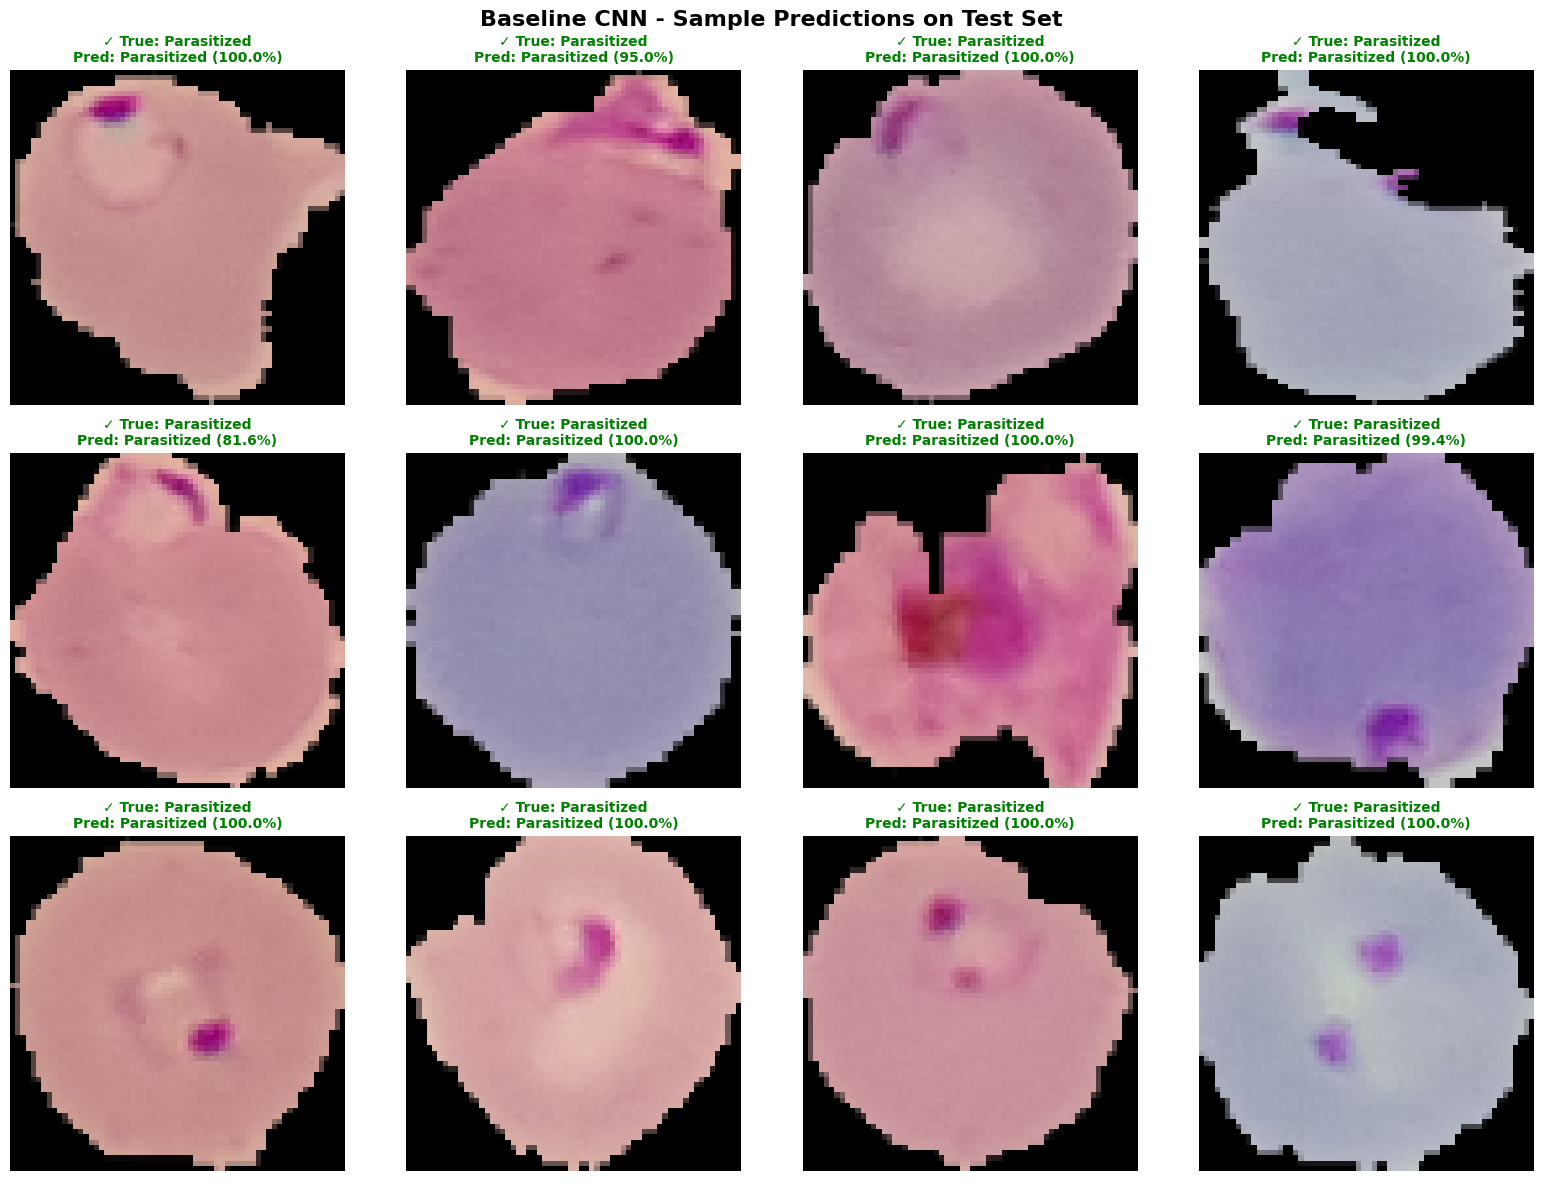


📊 SAMPLE PREDICTION SUMMARY:
   Correct predictions: 12/12 (100.0%)
   Incorrect predictions: 0/12

💡 LEGEND:
   ✓ Green border = Correct prediction
   ✗ Red border = Incorrect prediction
   Percentage = Model's confidence in its prediction

🔍 OBSERVATIONS:
   ✅ Perfect! All 12 samples predicted correctly!


In [ ]:
# Display sample predictions with images
print("🔬 Visualizing sample predictions from test set...\n")

# Get sample predictions
num_samples = 12
sample_images = []
sample_labels = []
sample_predictions = []

# Collect samples from test dataset
for images, labels in test_dataset.take(1):
    for i in range(min(num_samples, len(images))):
        img = images[i].numpy()
        label = int(labels[i].numpy())
        pred_prob = model.predict(tf.expand_dims(images[i], 0), verbose=0)[0][0]
        pred_class = 1 if pred_prob >= 0.5 else 0

        sample_images.append(img)
        sample_labels.append(label)
        sample_predictions.append((pred_class, pred_prob))

# Create visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Baseline CNN - Sample Predictions on Test Set', fontsize=16, fontweight='bold')

class_names = ['Uninfected', 'Parasitized']
correct_count = 0

for idx, (img, true_label, (pred_label, pred_prob)) in enumerate(zip(sample_images, sample_labels, sample_predictions)):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]

    # Display image
    ax.imshow(img)

    # Determine if prediction is correct
    is_correct = (pred_label == true_label)
    if is_correct:
        correct_count += 1

    # Color code: Green for correct, Red for incorrect
    border_color = 'green' if is_correct else 'red'
    title_symbol = '✓' if is_correct else '✗'

    # Create title
    true_class = class_names[true_label]
    pred_class = class_names[pred_label]
    confidence = pred_prob if pred_label == 1 else (1 - pred_prob)

    title = f'{title_symbol} True: {true_class}\nPred: {pred_class} ({confidence:.1%})'

    ax.set_title(title, fontweight='bold', fontsize=10, color=border_color)
    ax.axis('off')

    # Add colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n📊 SAMPLE PREDICTION SUMMARY:")
print(f"   Correct predictions: {correct_count}/{num_samples} ({correct_count/num_samples*100:.1f}%)")
print(f"   Incorrect predictions: {num_samples - correct_count}/{num_samples}")

print(f"\n💡 LEGEND:")
print(f"   ✓ Green border = Correct prediction")
print(f"   ✗ Red border = Incorrect prediction")
print(f"   Percentage = Model's confidence in its prediction")

print(f"\n🔍 OBSERVATIONS:")
if correct_count == num_samples:
    print(f"   ✅ Perfect! All {num_samples} samples predicted correctly!")
elif correct_count >= num_samples * 0.9:
    print(f"   ✅ Excellent! {correct_count/num_samples*100:.1f}% accuracy on this sample.")
else:
    print(f"   ⚠️  Some misclassifications detected. Review incorrect predictions.")

Results: Baseline CNN Model Evaluation

The evaluation of the baseline CNN model on the test dataset yielded the following results:

*   **Test Accuracy:** 0.9570 - This indicates that the model correctly classified approximately 95.70% of the test images.
*   **Test Loss:** 0.1690 - This is a measure of the model's error on the test set, with lower values indicating better performance.

**Classification Report**

*   **Precision:** For 'Uninfected', the precision is 0.9449, meaning that when the model predicted 'Uninfected', it was correct 94.49% of the time. For 'Parasitized', the precision is 0.9697.
*   **Recall:** For 'Uninfected', the recall is 0.9705, meaning the model correctly identified 97.05% of all actual 'Uninfected' cases. For 'Parasitized', the recall is 0.9434.
*   **F1-score:** The F1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance for each class. The F1-scores are 0.9575 for 'Uninfected' and 0.9564 for 'Parasitized'.
*   **Support:** This is the number of actual instances in each class in the test set (2068 for both).

The **Confusion Matrix** visually represents the model's predictions versus the actual labels:

*   **True Positives (TP):** 1951 (Correctly predicted Parasitized)
*   **True Negatives (TN):** 2007 (Correctly predicted Uninfected)
*   **False Positives (FP):** 61 (Predicted Parasitized, but actually Uninfected)
*   **False Negatives (FN):** 117 (Predicted Uninfected, but actually Parasitized)

The **ROC Curve** and **AUC (Area Under the Curve)** provide an overall measure of the model's ability to distinguish between the two classes. An AUC of 0.987 indicates excellent discriminatory power.


## Data Augmentation and Preprocessing ( for Pretrained models)

Data augmentation is a technique used to artificially increase the size of the training dataset by creating modified versions of existing images. This helps to improve the model's ability to generalize and reduce overfitting.(Data Camp)

The code below sets up the data preprocessing pipeline, including data augmentation for the training set.

In [ ]:
# Data augmentation and preprocessing pipeline setup
print("=== SETTING UP DATA PREPROCESSING PIPELINE ===")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.1,          # Random horizontal shift
    height_shift_range=0.1,         # Random vertical shift
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=False,            # No vertical flip (cells have orientation)
    fill_mode='nearest'             # Fill pixels after transformation
)

# Validation and test data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

print("✓ Data generators configured")
print("  - Training: with augmentation (rotation, shift, shear, zoom, flip)")
print("  - Validation/Test: only normalization")
print(f"  - Target image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")

=== SETTING UP DATA PREPROCESSING PIPELINE ===
✓ Data generators configured
  - Training: with augmentation (rotation, shift, shear, zoom, flip)
  - Validation/Test: only normalization
  - Target image size: 64x64
  - Batch size: 32


## Creating Data Generators

This cell utilizes the `ImageDataGenerator` to create data generators for the training, validation, and test sets. These generators are essential for efficiently loading and preprocessing images in batches during the model training process.

- The training generator (`train_generator`) applies the configured data augmentation techniques and normalization.
- The validation (`validation_generator`) and test (`test_generator`) generators only apply normalization, as augmentation is typically only used on the training data.

The `flow_from_directory` method is used to load images directly from the organized directory structure created earlier. Key parameters include:

- `target_size`: Resizes all images to the specified `IMG_SIZE`.
- `batch_size`: Defines the number of images per batch.
- `class_mode='binary'`: Indicates a binary classification problem (two classes).
- `shuffle=True` for training data to randomize the order of images in each epoch.
- `shuffle=False` for validation and test data to maintain consistent evaluation order.

Finally, the code converts the Keras generators to `tf.data.Dataset` objects and applies `prefetch` for optimized data loading during training.

In [ ]:
# Create data generators from directories
print("Creating data generators from directories...")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation
    width_shift_range=0.1,          # Random horizontal shift
    height_shift_range=0.1,         # Random vertical shift
    shear_range=0.1,                # Random shear transformation
    zoom_range=0.1,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=False,            # No vertical flip (cells have orientation)
    fill_mode='nearest'             # Fill pixels after transformation
)

# Validation and test data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)


# Training data generator
train_generator_raw = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',            # Binary classification (0: Parasitized, 1: Uninfected)
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator_raw = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Test data generator
test_generator_raw = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Apply prefetch for optimized pipeline
AUTOTUNE = tf.data.AUTOTUNE

train_generator = tf.data.Dataset.from_generator(
    lambda: train_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)

validation_generator = tf.data.Dataset.from_generator(
    lambda: validation_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)

test_generator = tf.data.Dataset.from_generator(
    lambda: test_generator_raw,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None])
).prefetch(buffer_size=AUTOTUNE)


print(f"\n✓ Data generators created successfully!")
# After converting to tf.data.Dataset, .samples, num_classes, and class_indices attributes are not available
# We will use the raw generators to get these details for printing
print(f"  - Training samples: {train_generator_raw.samples}")
print(f"  - Validation samples: {validation_generator_raw.samples}")
print(f"  - Test samples: {test_generator_raw.samples}")
print(f"  - Number of classes: {train_generator_raw.num_classes}")
print(f"  - Class indices: {train_generator_raw.class_indices}")


# Calculate steps per epoch
STEPS_PER_EPOCH = train_generator_raw.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator_raw.samples // BATCH_SIZE
TEST_STEPS = test_generator_raw.samples // BATCH_SIZE


print(f"\n✓ Steps per epoch calculated:")
print(f"  - Training steps per epoch: {STEPS_PER_EPOCH}")
print(f"  - Validation steps: {VALIDATION_STEPS}")
print(f"  - Test steps: {TEST_STEPS}")

Creating data generators from directories...
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.

✓ Data generators created successfully!
  - Training samples: 19290
  - Validation samples: 4132
  - Test samples: 4136
  - Number of classes: 2
  - Class indices: {'Parasitized': 0, 'Uninfected': 1}

✓ Steps per epoch calculated:
  - Training steps per epoch: 602
  - Validation steps: 129
  - Test steps: 129


# Visualize augmented training data samples

Visualizing 8 augmented training samples...


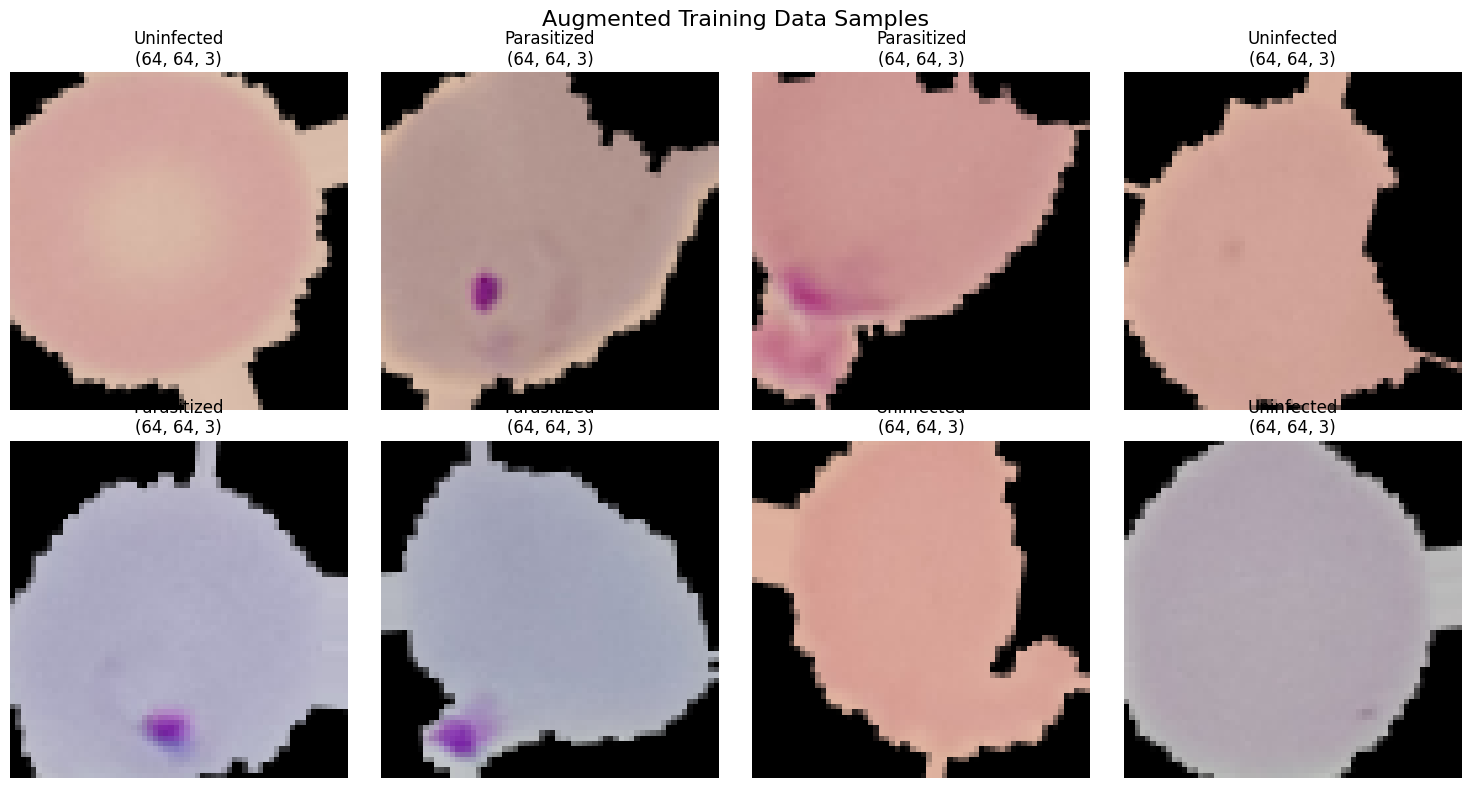

Sample batch shape: (32, 64, 64, 3)
Sample labels shape: (32,)
Pixel value range: [0.000, 0.887]


In [ ]:
# Visualize augmented training data samples
def visualize_augmented_data(generator, num_samples=8):
    """Visualize samples from the data generator"""
    print(f"Visualizing {num_samples} augmented training samples...")

    # Get a batch of data by iterating over the dataset and taking one batch
    for sample_batch, sample_labels in generator.take(1):
        # Convert tensors to numpy arrays for visualization
        sample_batch = sample_batch.numpy()
        sample_labels = sample_labels.numpy()

        plt.figure(figsize=(15, 8))
        for i in range(min(num_samples, len(sample_batch))):
            plt.subplot(2, 4, i+1)

            # Display image
            img = sample_batch[i]
            plt.imshow(img)

            # Get class name
            class_name = "Uninfected" if sample_labels[i] == 1 else "Parasitized"
            plt.title(f'{class_name}\n{img.shape}')
            plt.axis('off')

        plt.suptitle('Augmented Training Data Samples', fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"Sample batch shape: {sample_batch.shape}")
        print(f"Sample labels shape: {sample_labels.shape}")
        print(f"Pixel value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

# Visualize training data
visualize_augmented_data(train_generator)

# ResNet50 Transfer Learning Experimental Suite -- Orpheus Manga

This section implements a comprehensive experimental framework for ResNet50 transfer learning with:

- **3 Different Experiments** with varied hyperparameters
- **Complete Performance Evaluation** (Accuracy, Precision, Recall, F1-Score)
- **Visual Analysis** (Learning Curves, Confusion Matrices, ROC/AUC Curves)
- **Comparative Analysis** across all experiments
- **Best Model Selection** based on performance metrics

## Experimental Design

We will test different combinations of:
- Learning rates (0.001, 0.0005, 0.0001)
- Dropout rates (0.3, 0.5, 0.7)
- Dense layer sizes (128, 256, 512)
- Optimizers (Adam, SGD)
- Fine-tuning strategies (Frozen vs Partially Unfrozen)

In [ ]:
# Import ResNet50 and additional libraries for comprehensive evaluation
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import gc
import json

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✓ Additional libraries imported successfully")
print("✓ Ready to build ResNet50 transfer learning experiments")

✓ Additional libraries imported successfully
✓ Ready to build ResNet50 transfer learning experiments


In [ ]:
# Define 3 experimental configurations
experiments = [
    {
        'name': 'Experiment 1: Lower Learning Rate',
        'learning_rate': 0.0005,
        'optimizer': 'adam',
        'dropout_rate': 0.7,
        'dense_neurons': 256,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Reduced learning rate for more stable training and Increased regularization to prevent overfitting'
    },
    {
        'name': 'Experiment 2: Larger Dense Layer',
        'learning_rate': 0.001,
        'optimizer': 'sgd',
        'dropout_rate': 0.5,
        'dense_neurons': 512,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Increased model capacity with more neurons and Alternative optimizer with momentum'
    },
    {
        'name': 'Experiment 3: Fine-tuned ResNet50',
        'learning_rate': 0.0001,
        'optimizer': 'adam',
        'dropout_rate': 0.3,
        'dense_neurons': 256,
        'epochs': 30,
        'fine_tune': True,
        'description': 'Unfrozen top layers for fine-tuning'
    }
]

print(f" Defined {len(experiments)} experimental configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"  {i}. {exp['name']}")
    print(f"     {exp['description']}")

# Global variables to store results
experiment_results = []
all_histories = []

 Defined 3 experimental configurations:
  1. Experiment 1: Lower Learning Rate
     Reduced learning rate for more stable training and Increased regularization to prevent overfitting
  2. Experiment 2: Larger Dense Layer
     Increased model capacity with more neurons and Alternative optimizer with momentum
  3. Experiment 3: Fine-tuned ResNet50
     Unfrozen top layers for fine-tuning


## Model Definition: `create_resnet_model` Function

`create_resnet_model` function. This function builds a transfer learning model using the pre-trained ResNet50 model. It allows for freezing or fine-tuning the ResNet50 base and adds custom layers for binary classification, including dense layers and dropout for regularization.

In [ ]:
# Function to create ResNet50 transfer learning model
def create_resnet_model(config):
    """
    Create a ResNet50 transfer learning model with specified configuration

    Args:
        config: Dictionary containing model configuration parameters

    Returns:
        Compiled Keras model
    """
    print(f"\n Building model: {config['name']}")
    print(f"   Configuration: LR={config['learning_rate']}, Dropout={config['dropout_rate']}, "
          f"Dense={config['dense_neurons']}, Fine-tune={config['fine_tune']}")

    # Clear any previous models from memory
    tf.keras.backend.clear_session()

    # Load pre-trained ResNet50 base
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Configure base model trainability
    if config['fine_tune']:
        # Freeze early layers, allow fine-tuning of later layers
        base_model.trainable = True
        # Freeze the first 100 layers (out of 175 total)
        for layer in base_model.layers[:100]:
            layer.trainable = False
        print(f"   Fine-tuning enabled: {len([l for l in base_model.layers if l.trainable])} trainable layers")
    else:
        # Freeze all layers in base model
        base_model.trainable = False
        print(f"   Base model frozen: {len(base_model.layers)} layers")

    # Build the complete model
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(config['dense_neurons'], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Configure optimizer
    if config['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=config['learning_rate'],
            momentum=0.9
        )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"   Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"   Trainable parameters: {trainable_params:,}")

    return model

print(" ResNet50 model creation function defined")

 ResNet50 model creation function defined


## Comprehensive Model Evaluation: `evaluate_model_comprehensive` Function

The function systematically generates predictions on the test dataset and calculates key classification metrics, including accuracy, precision, recall, F1-score, and ROC-AUC. It also produces a suite of visualizations, such as learning curves, confusion matrices, and ROC curves, to provide insights into model behavior and performance characteristics.

In [ ]:
# Comprehensive model evaluation function
def evaluate_model_comprehensive(model, history, config, exp_number):
    """
    Perform comprehensive evaluation with detailed visualizations and metrics

    Args:
        model: Trained Keras model
        history: Training history object
        config: Experiment configuration
        exp_number: Experiment number for identification

    Returns:
        Dictionary containing all evaluation metrics and results
    """
    print(f"\n{'='*70}")
    print(f"📊 COMPREHENSIVE EVALUATION: {config['name']}")
    print("="*70)

    # Get predictions on test set
    print(" Generating predictions on test set...")
    test_generator_raw.reset()

    # Get true labels and predictions
    y_true = test_generator_raw.classes
    # Use the raw generator directly for prediction and let it determine steps
    y_pred_prob = model.predict(test_generator_raw, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_prob = y_pred_prob.flatten()

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print(f"📈 PERFORMANCE METRICS:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")

    # Create comprehensive visualization
    create_evaluation_plots(history, cm, fpr, tpr, roc_auc, y_true, y_pred_prob, config, exp_number)

    # Print detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    target_names = ['Parasitized', 'Uninfected']
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # Store results
    results = {
        'experiment': config['name'],
        'exp_number': exp_number,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'config': config.copy(),
        'confusion_matrix': cm.tolist(),
        'test_samples': len(y_true),
        'final_train_acc': history.history['accuracy'][-1] if history.history['accuracy'] else None,
        'final_val_acc': history.history['val_accuracy'][-1] if history.history['val_accuracy'] else None,
        'final_train_loss': history.history['loss'][-1] if history.history['loss'] else None,
        'final_val_loss': history.history['val_loss'][-1] if history.history['val_loss'] else None,
        'epochs_trained': len(history.history['loss'])
    }

    return results

def create_evaluation_plots(history, cm, fpr, tpr, roc_auc, y_true, y_pred_prob, config, exp_number, model_type='Model'):
    """
    Universal function to create comprehensive evaluation plots

    Args:
        history: Training history object
        cm: Confusion matrix
        fpr, tpr: ROC curve data
        roc_auc: ROC AUC score
        y_true: True labels
        y_pred_prob: Predicted probabilities
        config: Experiment configuration
        exp_number: Experiment number
        model_type: Type of model for titles
    """
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'{config["name"]} ({model_type}) - Comprehensive Evaluation',
                fontsize=16, fontweight='bold', y=0.98)

    # 1. Training History - Loss
    ax1 = plt.subplot(3, 4, 1)
    if history and history.history.get('loss'):
        epochs = range(1, len(history.history['loss']) + 1)
        ax1.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Training Loss')
        ax1.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
        ax1.set_title('Model Loss', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add interpretation text
        min_val_loss = min(history.history['val_loss'])
        min_val_epoch = history.history['val_loss'].index(min_val_loss) + 1
        ax1.text(0.05, 0.95, f'Best Val Loss: {min_val_loss:.4f}\nat Epoch: {min_val_epoch}',
                transform=ax1.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        ax1.text(0.5, 0.5, 'No Training\nHistory Available', ha='center', va='center',
                transform=ax1.transAxes, fontsize=14)
        ax1.set_title('Model Loss', fontweight='bold', fontsize=12)

    # 2. Training History - Accuracy
    ax2 = plt.subplot(3, 4, 2)
    if history and history.history.get('accuracy'):
        epochs = range(1, len(history.history['accuracy']) + 1)
        ax2.plot(epochs, history.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
        ax2.plot(epochs, history.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
        ax2.set_title('Model Accuracy', fontweight='bold', fontsize=12)
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Add interpretation text
        max_val_acc = max(history.history['val_accuracy'])
        max_acc_epoch = history.history['val_accuracy'].index(max_val_acc) + 1
        ax2.text(0.05, 0.95, f'Best Val Acc: {max_val_acc:.4f}\nat Epoch: {max_acc_epoch}',
                transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    else:
        ax2.text(0.5, 0.5, 'No Training\nHistory Available', ha='center', va='center',
                transform=ax2.transAxes, fontsize=14)
        ax2.set_title('Model Accuracy', fontweight='bold', fontsize=12)

    # 3. Confusion Matrix
    ax3 = plt.subplot(3, 4, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    ax3.set_title('Confusion Matrix', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')

    # Add confusion matrix metrics
    tn, fp, fn, tp = cm.ravel()
    ax3.text(1.05, 0.5, f'TP: {tp}\nTN: {tn}\nFP: {fp}\nFN: {fn}',
            transform=ax3.transAxes, fontsize=10, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

    # 4. ROC Curve
    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8, label='Random')
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curve', fontweight='bold', fontsize=12)
    ax4.legend(loc="lower right")
    ax4.grid(True, alpha=0.3)

    # 5. Prediction Distribution
    ax5 = plt.subplot(3, 4, 5)
    ax5.hist(y_pred_prob[y_true == 0], bins=30, alpha=0.7, label='Parasitized', color='red')
    ax5.hist(y_pred_prob[y_true == 1], bins=30, alpha=0.7, label='Uninfected', color='blue')
    ax5.axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Threshold')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Prediction Distribution', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Model Configuration Summary
    ax6 = plt.subplot(3, 4, 6)
    ax6.axis('off')
    config_text = f"""
    Model Type: {model_type}
    Experiment: {exp_number}

    Configuration:
    • Learning Rate: {config.get('learning_rate', 'N/A')}
    • Dropout Rate: {config.get('dropout_rate', 'N/A')}
    • Dense Neurons: {config.get('dense_neurons', 'N/A')}
    • Fine-tuning: {config.get('fine_tune', 'N/A')}
    • Epochs: {config.get('epochs', 'N/A')}
    """
    ax6.text(0.1, 0.9, config_text, transform=ax6.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

    # 7-12: Additional space for future metrics or custom plots
    for i, pos in enumerate([(3, 4, 7), (3, 4, 8), (3, 4, 9), (3, 4, 10), (3, 4, 11), (3, 4, 12)]):
        ax = plt.subplot(*pos)
        ax.axis('off')
        if i == 0:  # First extra subplot
            performance_text = f"""
            Performance Summary:

            • Accuracy: {accuracy_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
            • Precision: {precision_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
            • Recall: {recall_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
            • F1-Score: {f1_score(y_true, (y_pred_prob > 0.5).astype(int)):.4f}
            • ROC-AUC: {roc_auc:.4f}
            """
            ax.text(0.1, 0.9, performance_text, transform=ax.transAxes, fontsize=11,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Save the plot
    plot_filename = f"{model_type.replace(' ', '_')}_{config['name'].replace(' ', '_')}_evaluation.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"📊 Evaluation plot saved as: {plot_filename}")

## Running a Single Experiment: `run_single_experiment` Function

`run_single_experiment` function. This function is designed to manage the execution of a single experiment within the transfer learning suite. It encompasses the sequential steps of building the model according to the specified configuration, setting up callbacks for monitoring and dynamic learning rate adjustments, training the model using the prepared data generators, performing a comprehensive evaluation of the trained model, and finally, storing the results and cleaning up resources before proceeding to the next experiment.

In [ ]:
# Function to run a single experiment
def run_single_experiment(config, exp_number, total_experiments):
    """
    Run a single experiment with comprehensive evaluation

    Args:
        config: Experiment configuration dictionary
        exp_number: Current experiment number
        total_experiments: Total number of experiments

    Returns:
        Dictionary containing experiment results
    """
    print(f"\n {'='*80}")
    print(f"EXPERIMENT {exp_number}/{total_experiments}: {config['name']}")
    print(f"{'='*80}")
    print(f"Description: {config['description']}")
    print(f"⏰ Started at: {datetime.now().strftime('%H:%M:%S')}")

    start_time = datetime.now()

    try:
        # Create model
        model = create_resnet_model(config)

        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]

        print(f"\n Training model for up to {config['epochs']} epochs...")

        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=config['epochs'],
            validation_data=validation_generator,
            validation_steps=VALIDATION_STEPS,
            callbacks=callbacks,
            verbose=1
        )

        end_time = datetime.now()
        training_duration = (end_time - start_time).total_seconds() / 60

        print(f"\n Training completed in {training_duration:.2f} minutes")
        print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
        print(f"   Epochs trained: {len(history.history['loss'])}")

        # Comprehensive evaluation
        results = evaluate_model_comprehensive(model, history, config, exp_number)
        results['training_duration_minutes'] = training_duration

        # Store results and history
        experiment_results.append(results)
        all_histories.append({
            'experiment': config['name'],
            'history': history.history,
            'config': config.copy()
        })

        print(f"\n EXPERIMENT {exp_number} SUMMARY:")
        print(f"   Test Accuracy: {results['accuracy']:.4f}")
        print(f"   F1-Score: {results['f1_score']:.4f}")
        print(f"   ROC-AUC: {results['roc_auc']:.4f}")
        print(f"   Training Time: {training_duration:.2f} minutes")

        # Clean up memory
        del model
        gc.collect()

        return results

    except Exception as e:
        print(f"\n❌ ERROR in {config['name']}: {str(e)}")
        print(f"Skipping to next experiment...")
        return None

print("✓ Single experiment runner function defined")

✓ Single experiment runner function defined


# Visualization and Analysis Helper Functions

This cell contains helper functions designed to facilitate the visualization and analysis of the experimental results after all models have been trained.

- `create_final_comparison_plots(df_results)`: Generates a comprehensive set of plots to visually compare the performance of all experiments. This includes bar charts for key metrics, training time vs. performance scatter plot, validation accuracy convergence curves, hyperparameter impact analysis, and a performance heatmap.
- `analyze_hyperparameter_impact(df_results)`: Performs a textual analysis of how different hyperparameters (learning rate, dropout, dense layer size, optimizer, fine-tuning) influenced the model's performance (specifically focusing on F1-score).
- `export_results(df_results)`: Exports the experimental results to both a CSV file (for easy viewing in a spreadsheet) and a JSON file (for detailed programmatic access), ensuring that the findings are saved for future reference.

These functions are called by the main `run_all_experiments` function to provide a complete overview and analysis of the experimental suite.

In [ ]:
# ===== UNIVERSAL COMPARISON AND EXPORT FUNCTIONS =====

def create_final_comparison_plots(df_results, model_name='Model'):
    """
    Universal function to create comprehensive comparison plots across experiments

    Args:
        df_results: DataFrame containing experiment results
        model_name: Name of the model type for titles and filenames
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle(f'{model_name} - Comprehensive Experimental Comparison',
                fontsize=16, fontweight='bold')

    # 1. Performance Metrics Comparison
    ax1 = axes[0, 0]
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    x = np.arange(len(df_results))
    width = 0.15

    for i, metric in enumerate(metrics):
        ax1.bar(x + i*width, df_results[metric], width,
               label=metric.replace('_', '-').title(), alpha=0.8)

    ax1.set_xlabel('Experiments')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics Comparison', fontweight='bold')
    ax1.set_xticks(x + width*2)
    ax1.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))], rotation=45)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. F1-Score vs Training Time (if available)
    ax2 = axes[0, 1]
    if 'epochs_trained' in df_results.columns:
        scatter = ax2.scatter(df_results['epochs_trained'], df_results['f1_score'],
                            c=df_results['accuracy'], s=100, alpha=0.7, cmap='viridis')
        ax2.set_xlabel('Epochs Trained')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('Training Efficiency\n(Epochs vs Performance)', fontweight='bold')
        plt.colorbar(scatter, ax=ax2, label='Accuracy')

        # Add experiment labels
        for i, row in df_results.iterrows():
            ax2.annotate(f'E{i+1}', (row['epochs_trained'], row['f1_score']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    else:
        ax2.bar(range(len(df_results)), df_results['f1_score'], alpha=0.7, color='skyblue')
        ax2.set_xlabel('Experiments')
        ax2.set_ylabel('F1-Score')
        ax2.set_title('F1-Score Comparison', fontweight='bold')
        ax2.set_xticks(range(len(df_results)))
        ax2.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))])
    ax2.grid(True, alpha=0.3)

    # 3. ROC-AUC Comparison
    ax3 = axes[0, 2]
    bars = ax3.bar(range(len(df_results)), df_results['roc_auc'],
                  color='purple', alpha=0.7)
    ax3.set_xlabel('Experiments')
    ax3.set_ylabel('ROC-AUC')
    ax3.set_title('ROC-AUC Comparison', fontweight='bold')
    ax3.set_xticks(range(len(df_results)))
    ax3.set_xticklabels([f'Exp {i+1}' for i in range(len(df_results))])

    # Add value labels on bars
    for i, (bar, auc_val) in enumerate(zip(bars, df_results['roc_auc'])):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    ax3.grid(True, alpha=0.3)

    # 4-9. Additional comparison plots (hyperparameter analysis, etc.)
    remaining_positions = [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

    for i, pos in enumerate(remaining_positions):
        ax = axes[pos]
        if i == 0:  # Accuracy vs Precision scatter
            ax.scatter(df_results['accuracy'], df_results['precision'],
                      s=100, alpha=0.7, c='orange')
            ax.set_xlabel('Accuracy')
            ax.set_ylabel('Precision')
            ax.set_title('Accuracy vs Precision', fontweight='bold')
            for j, row in df_results.iterrows():
                ax.annotate(f'E{j+1}', (row['accuracy'], row['precision']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        elif i == 1:  # Performance Heatmap
            if len(df_results) > 1:
                heatmap_data = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].T
                heatmap_data.columns = [f'Exp {j+1}' for j in range(len(df_results))]
                sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax,
                           cbar_kws={'label': 'Score'}, vmin=0.7, vmax=1.0)
                ax.set_title('Performance Heatmap', fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'Need multiple\nexperiments', ha='center', va='center',
                       transform=ax.transAxes, fontsize=12)
                ax.set_title('Performance Heatmap', fontweight='bold')
        else:
            ax.axis('off')
            if i == 2:  # Summary statistics
                best_idx = df_results['f1_score'].idxmax()
                summary_text = f"""
                Best Performing Experiment:
                {df_results.iloc[best_idx]['experiment']}

                Best Scores:
                • Accuracy: {df_results['accuracy'].max():.4f}
                • F1-Score: {df_results['f1_score'].max():.4f}
                • ROC-AUC: {df_results['roc_auc'].max():.4f}

                Average Performance:
                • Accuracy: {df_results['accuracy'].mean():.4f}±{df_results['accuracy'].std():.4f}
                • F1-Score: {df_results['f1_score'].mean():.4f}±{df_results['f1_score'].std():.4f}
                """
                ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Save the plot
    plot_filename = f"{model_name.replace(' ', '_')}_comparison_plots.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"📊 Evaluation plot saved as: {plot_filename}")


def analyze_hyperparameter_impact(df_results):
    """
    Universal function to analyze hyperparameter impact on performance

    Args:
        df_results: DataFrame containing experiment results with config column
    """
    print(f"\n🔍 HYPERPARAMETER IMPACT ANALYSIS:")
    print("="*60)

    if 'config' not in df_results.columns:
        print("⚠️  No configuration data available for analysis")
        return

    # Learning Rate Analysis
    if any('learning_rate' in config for config in df_results['config']):
        print(f"\n📊 Learning Rate Impact:")
        lr_analysis = df_results.groupby(df_results['config'].apply(
            lambda x: x.get('learning_rate', 'N/A')))['f1_score'].agg(['mean', 'std', 'count'])
        for lr, stats in lr_analysis.iterrows():
            if lr != 'N/A':
                print(f"   LR {lr:>8}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Dropout Rate Analysis
    if any('dropout_rate' in config for config in df_results['config']):
        print(f"\n📊 Dropout Rate Impact:")
        dropout_analysis = df_results.groupby(df_results['config'].apply(
            lambda x: x.get('dropout_rate', 'N/A')))['f1_score'].agg(['mean', 'std', 'count'])
        for dr, stats in dropout_analysis.iterrows():
            if dr != 'N/A':
                print(f"   Dropout {dr}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Dense Layer Analysis
    if any('dense_neurons' in config for config in df_results['config']):
        print(f"\n📊 Dense Layer Size Impact:")
        neurons_analysis = df_results.groupby(df_results['config'].apply(
            lambda x: x.get('dense_neurons', 'N/A')))['f1_score'].agg(['mean', 'std', 'count'])
        for neurons, stats in neurons_analysis.iterrows():
            if neurons != 'N/A':
                print(f"   {neurons} neurons: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")

    # Fine-tuning Analysis
    if any('fine_tune' in config for config in df_results['config']):
        print(f"\n📊 Fine-tuning Impact:")
        ft_analysis = df_results.groupby(df_results['config'].apply(
            lambda x: x.get('fine_tune', 'N/A')))['f1_score'].agg(['mean', 'std', 'count'])
        for ft, stats in ft_analysis.iterrows():
            if ft != 'N/A':
                ft_label = "Fine-tuned" if ft else "Frozen"
                print(f"   {ft_label:>10}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={int(stats['count'])})")


def export_results(df_results, model_name='Model'):
    """
    Universal function to export experiment results to CSV and JSON

    Args:
        df_results: DataFrame containing experiment results
        model_name: Name of model for filename
    """
    from datetime import datetime
    import json

    print(f"\n💾 EXPORTING {model_name.upper()} RESULTS:")

    # Export to CSV
    csv_filename = f"{model_name.replace(' ', '_')}_experiments_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_export = df_results.copy()

    # Convert config column to string for CSV compatibility
    if 'config' in df_export.columns:
        df_export['config_str'] = df_export['config'].astype(str)
        df_export = df_export.drop('config', axis=1)

    df_export.to_csv(csv_filename, index=False)
    print(f"   📄 CSV exported: {csv_filename}")

    # Export detailed results to JSON (if experiment_results exists)
    json_filename = f"{model_name.replace(' ', '_')}_detailed_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    export_data = {
        'model_name': model_name,
        'export_timestamp': datetime.now().isoformat(),
        'experiment_results': df_results.to_dict('records'),
        'summary_statistics': {
            'mean_accuracy': df_results['accuracy'].mean(),
            'std_accuracy': df_results['accuracy'].std(),
            'mean_f1_score': df_results['f1_score'].mean(),
            'std_f1_score': df_results['f1_score'].std(),
            'best_experiment': df_results.iloc[df_results['f1_score'].idxmax()]['experiment'] if len(df_results) > 0 else None,
            'best_f1_score': df_results['f1_score'].max() if len(df_results) > 0 else None,
            'total_experiments': len(df_results)
        }
    }

    # Add training histories if available globally and correctly access history data
    if 'all_histories' in globals():
        export_data['training_histories'] = [
            {f'experiment_{i}': hist_dict.get('history', {})} for i, hist_dict in enumerate(all_histories, 1)
        ]


    with open(json_filename, 'w') as f:
        json.dump(export_data, f, indent=2, default=str)
    print(f"   📄 JSON exported: {json_filename}")

    print(f"   ✅ All {model_name} results successfully exported!")

print("✅ Universal comparison and export functions defined")

✅ Universal comparison and export functions defined


In [ ]:
# MAIN EXPERIMENTAL SUITE FUNCTIONS

# Function to run all experiments and generate comparative analysis
def run_all_experiments():
    """
    Run all 7 experiments sequentially and generate comprehensive comparative analysis
    """
    print(f"\n STARTING RESNET50 EXPERIMENTAL SUITE")
    print(f"{'='*100}")
    print(f"📊 Total experiments to run: {len(experiments)}")
    print(f"🕐 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💾 Results will be automatically saved and compared")

    suite_start_time = datetime.now()
    successful_experiments = 0

    # Run each experiment
    for i, config in enumerate(experiments, 1):
        result = run_single_experiment(config, i, len(experiments))
        if result is not None:
            successful_experiments += 1

            # Show intermediate rankings
            if successful_experiments > 1:
                print(f"\n📈 CURRENT RANKINGS (by F1-Score):")
                temp_df = pd.DataFrame(experiment_results).sort_values('f1_score', ascending=False)
                for idx, row in temp_df.head(3).iterrows():
                    print(f"   {idx+1}. {row['experiment']} - F1: {row['f1_score']:.4f}")

        # Estimate remaining time
        if i < len(experiments):
            elapsed = (datetime.now() - suite_start_time).total_seconds() / 60
            estimated_remaining = (elapsed / i) * (len(experiments) - i)
            print(f"\n⏱️  Progress: {i}/{len(experiments)} | Estimated time remaining: {estimated_remaining:.1f} minutes")

    suite_end_time = datetime.now()
    total_duration = (suite_end_time - suite_start_time).total_seconds() / 60

    print(f"\n EXPERIMENTAL SUITE COMPLETED!")
    print(f"   Total time: {total_duration:.2f} minutes")
    print(f"   Successful experiments: {successful_experiments}/{len(experiments)}")
    if successful_experiments > 0:
        print(f"   Average time per experiment: {total_duration/successful_experiments:.2f} minutes")

    # Generate comprehensive comparative analysis
    if successful_experiments > 0:
        return generate_final_comparative_analysis()
    else:
        print("❌ No successful experiments to analyze.")
        return None

def generate_final_comparative_analysis():
    """
    Generate comprehensive comparative analysis across all experiments
    """
    if not experiment_results:
        print("No experiment results to analyze.")
        return None

    print(f"\n{'='*100}")
    print(f"📊 COMPREHENSIVE COMPARATIVE ANALYSIS")
    print(f"{'='*100}")

    # Create results DataFrame
    df_results = pd.DataFrame(experiment_results)
    df_results = df_results.sort_values('f1_score', ascending=False).reset_index(drop=True)

    # Display performance table
    print(f"\n FINAL PERFORMANCE TABLE (Ranked by F1-Score):")
    print("="*120)

    display_columns = ['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_duration_minutes']
    display_df = df_results[display_columns].copy()
    display_df.columns = ['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Time (min)']

    # Format numeric columns
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    display_df['Time (min)'] = display_df['Time (min)'].apply(lambda x: f"{x:.1f}")

    print(display_df.to_string(index=False))

    # Statistical analysis
    print(f"\n📈 STATISTICAL SUMMARY:")
    print(f"   Mean Accuracy: {df_results['accuracy'].mean():.4f} ± {df_results['accuracy'].std():.4f}")
    print(f"   Mean F1-Score: {df_results['f1_score'].mean():.4f} ± {df_results['f1_score'].std():.4f}")
    print(f"   Mean ROC-AUC: {df_results['roc_auc'].mean():.4f} ± {df_results['roc_auc'].std():.4f}")
    print(f"   Total Training Time: {df_results['training_duration_minutes'].sum():.1f} minutes")

    # Best and worst performers
    best_exp = df_results.iloc[0]
    worst_exp = df_results.iloc[-1]

    print(f"\n🥇 BEST PERFORMER:")
    print(f"   {best_exp['experiment']}")
    print(f"   F1-Score: {best_exp['f1_score']:.4f} | Accuracy: {best_exp['accuracy']:.4f} | ROC-AUC: {best_exp['roc_auc']:.4f}")
    print(f"   Configuration: {best_exp['config']}")

    print(f"\n LOWEST PERFORMER:")
    print(f"   {worst_exp['experiment']}")
    print(f"   F1-Score: {worst_exp['f1_score']:.4f} | Accuracy: {worst_exp['accuracy']:.4f} | ROC-AUC: {worst_exp['roc_auc']:.4f}")

    # Create comprehensive comparison visualizations
    create_final_comparison_plots(df_results)

    # Hyperparameter analysis
    analyze_hyperparameter_impact(df_results)

    # Export results
    export_results(df_results)

    return df_results

print("✓ Main experimental suite functions defined and ready to use!")

✓ Main experimental suite functions defined and ready to use!



 STARTING RESNET50 EXPERIMENTAL SUITE
📊 Total experiments to run: 3
🕐 Started at: 2025-10-05 18:20:27
💾 Results will be automatically saved and compared

EXPERIMENT 1/3: Experiment 1: Lower Learning Rate
Description: Reduced learning rate for more stable training and Increased regularization to prevent overfitting
⏰ Started at: 18:20:27

 Building model: Experiment 1: Lower Learning Rate
   Configuration: LR=0.0005, Dropout=0.7, Dense=256, Fine-tune=False
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
   Base model frozen: 175 layers
   Total parameters: 24,112,513
   Trainable parameters: 524,801

 Training model for up to 25 epochs...
Epoch 1/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 71s 96ms/step - accuracy: 0.5226 - loss: 0.7219 - val_accuracy: 0.6301 - val_loss: 0.6659 - learning_rate: 5.0000e-04
Epoch 2/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.5683 - loss: 0.6785 - val_accuracy: 0.5873 - val_loss: 0.6650 - learning_rate: 5.0000e-04
Epoch 3/25
602/602 ━━━━━━━━━━━━━━━

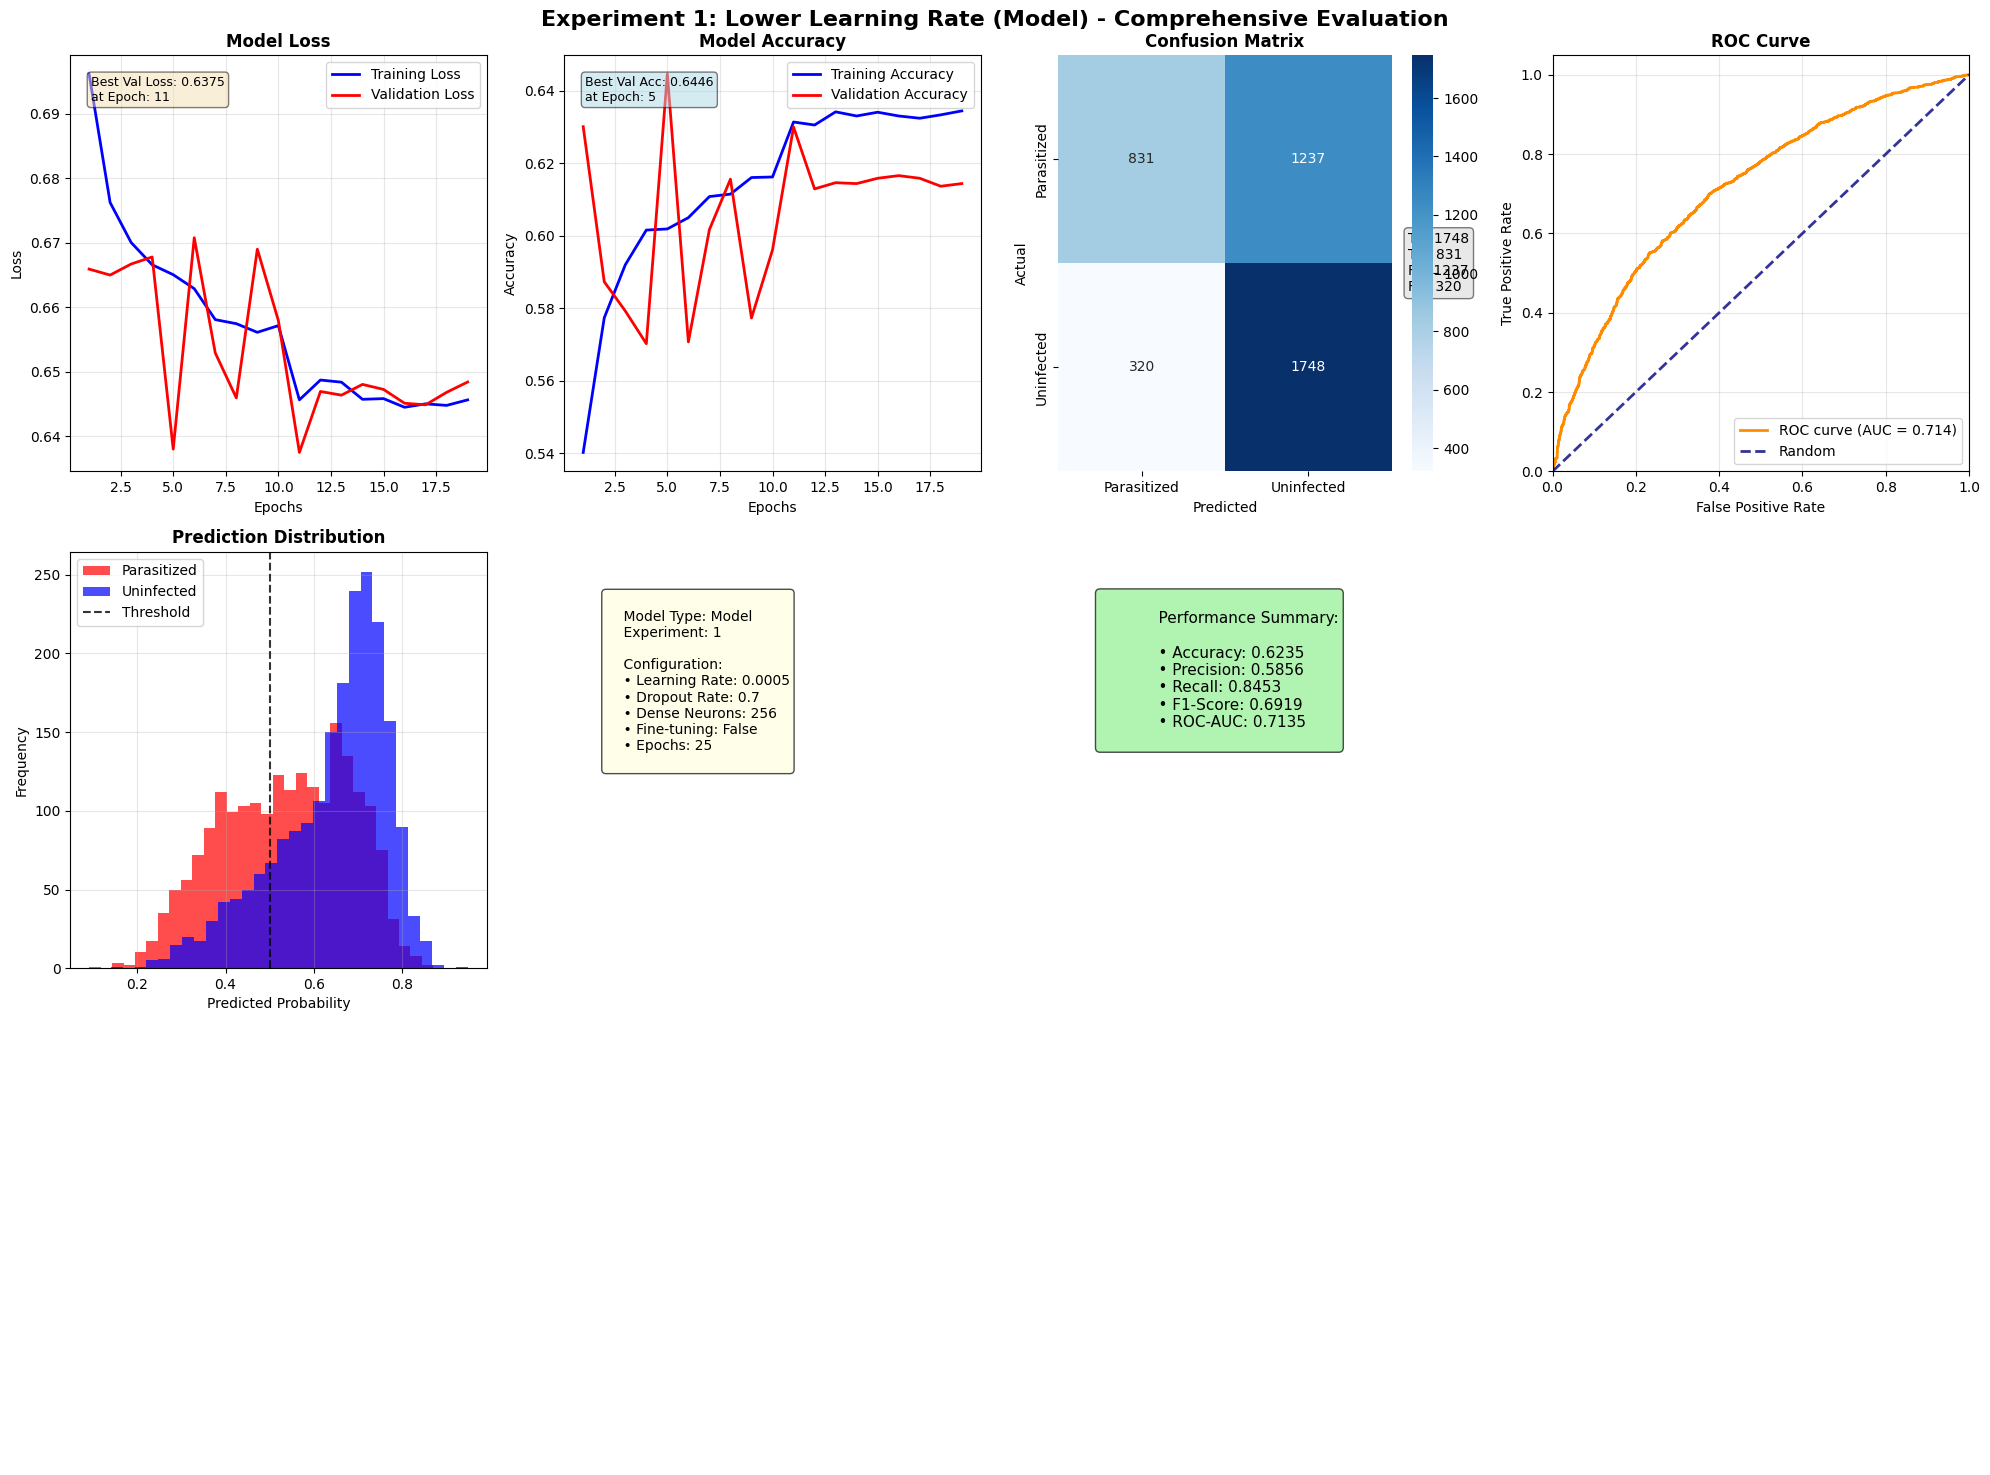

📊 Evaluation plot saved as: Model_Experiment_1:_Lower_Learning_Rate_evaluation.png

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.7220    0.4018    0.5163      2068
  Uninfected     0.5856    0.8453    0.6919      2068

    accuracy                         0.6235      4136
   macro avg     0.6538    0.6235    0.6041      4136
weighted avg     0.6538    0.6235    0.6041      4136


 EXPERIMENT 1 SUMMARY:
   Test Accuracy: 0.6235
   F1-Score: 0.6919
   ROC-AUC: 0.7135
   Training Time: 15.52 minutes

⏱️  Progress: 1/3 | Estimated time remaining: 31.5 minutes

EXPERIMENT 2/3: Experiment 2: Larger Dense Layer
Description: Increased model capacity with more neurons and Alternative optimizer with momentum
⏰ Started at: 18:36:12

 Building model: Experiment 2: Larger Dense Layer
   Configuration: LR=0.001, Dropout=0.5, Dense=512, Fine-tune=False
   Base model frozen: 175 layers
   Total parameters: 24,637,313
   Trainable parameter

<Figure size 640x480 with 0 Axes>

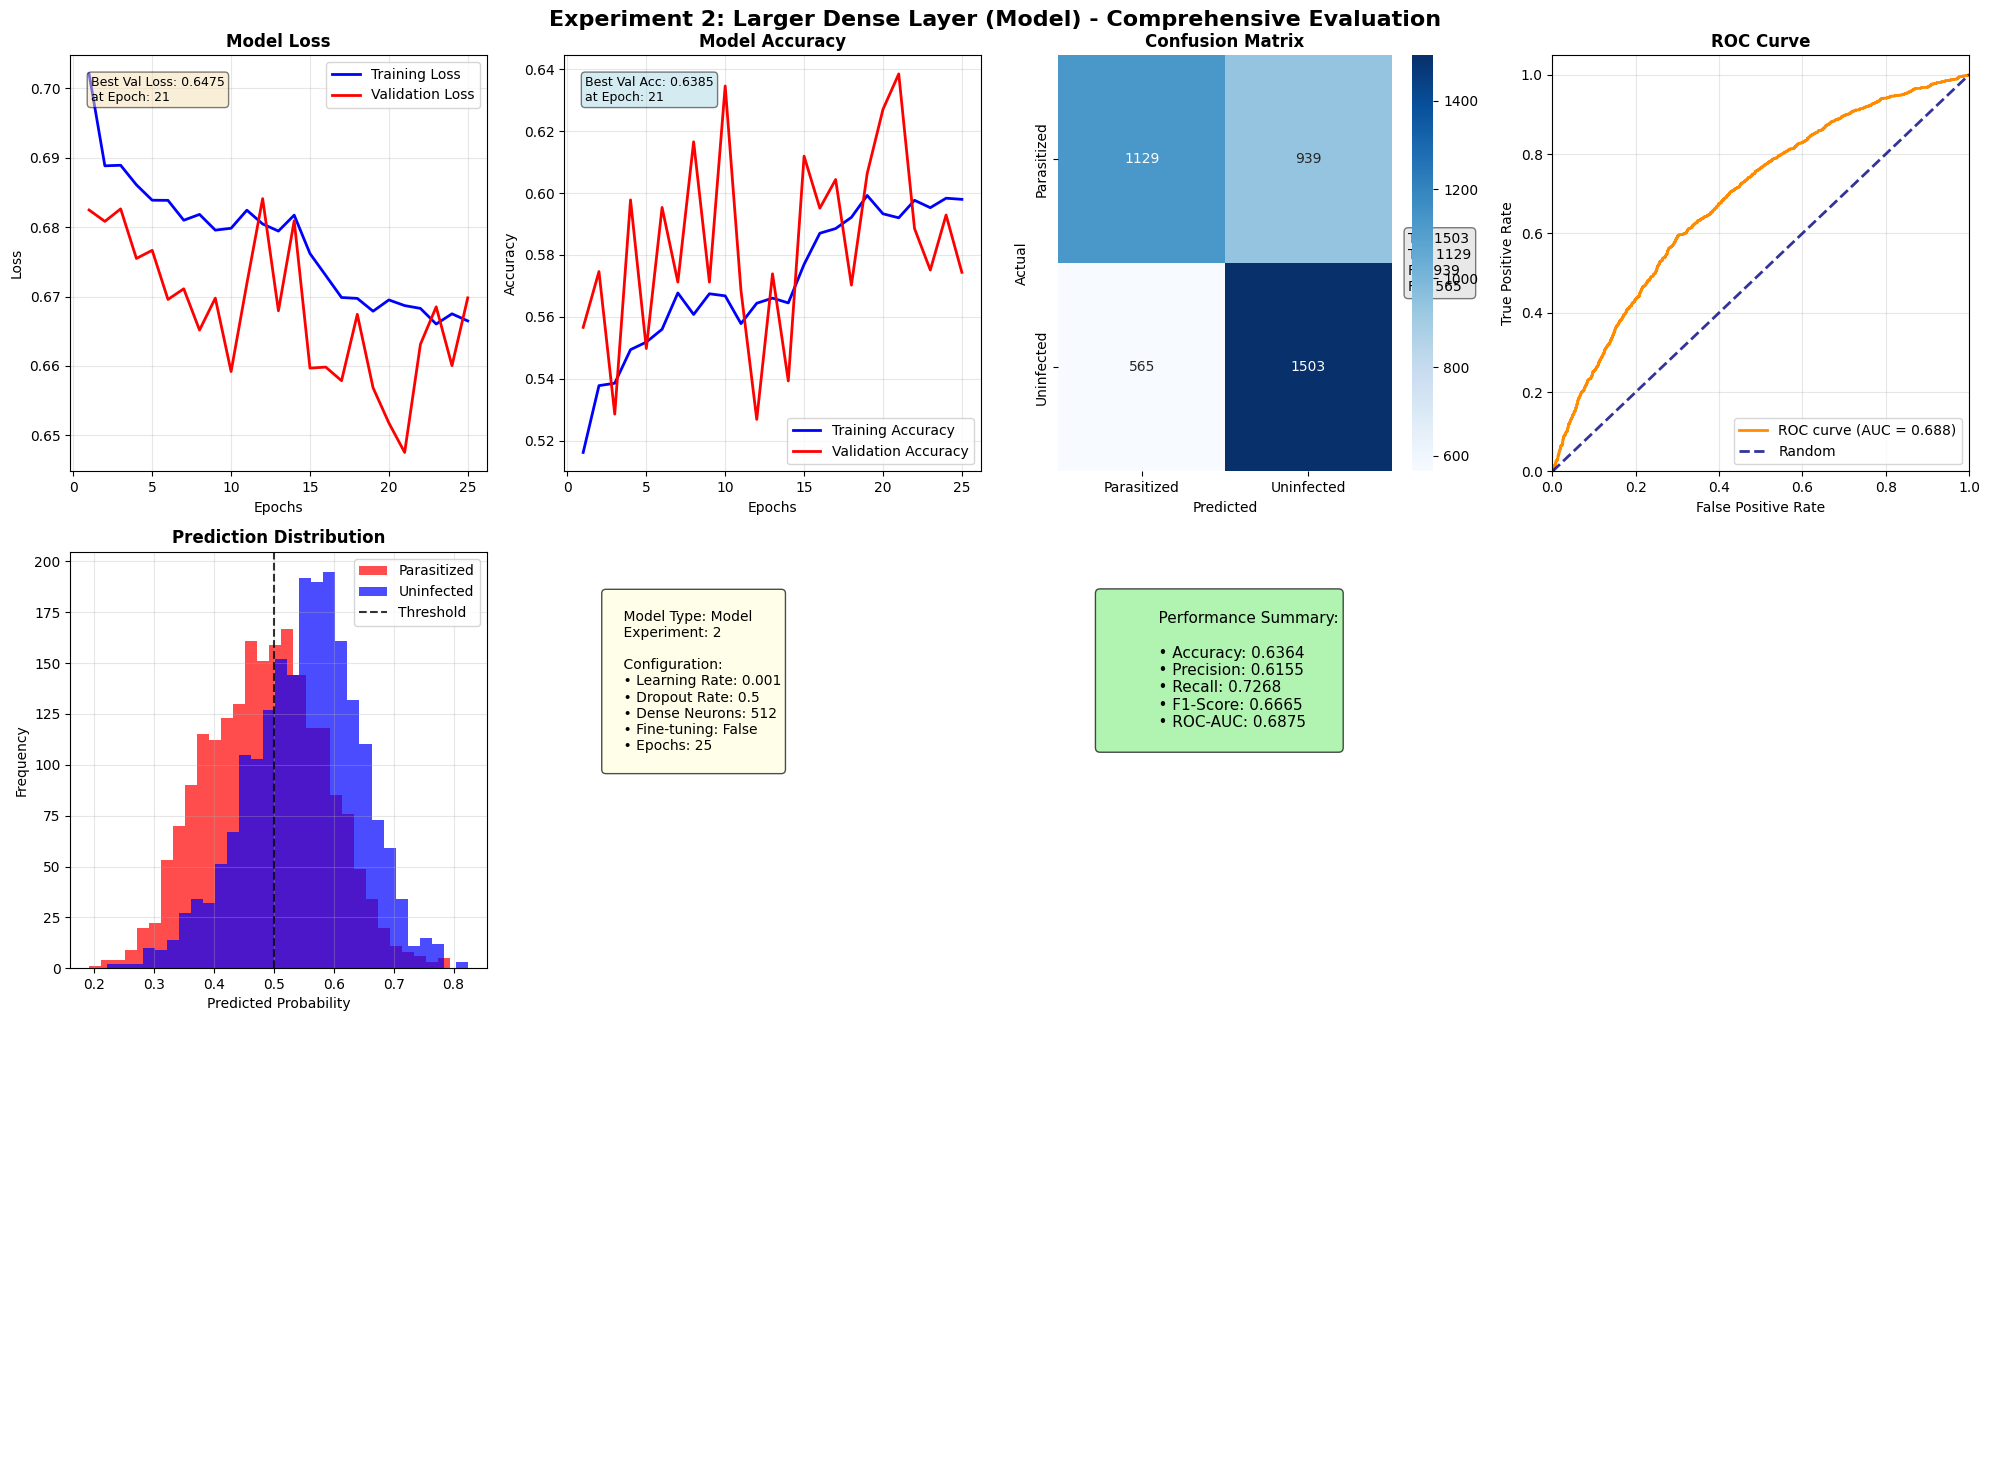

📊 Evaluation plot saved as: Model_Experiment_2:_Larger_Dense_Layer_evaluation.png

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.6665    0.5459    0.6002      2068
  Uninfected     0.6155    0.7268    0.6665      2068

    accuracy                         0.6364      4136
   macro avg     0.6410    0.6364    0.6334      4136
weighted avg     0.6410    0.6364    0.6334      4136


 EXPERIMENT 2 SUMMARY:
   Test Accuracy: 0.6364
   F1-Score: 0.6665
   ROC-AUC: 0.6875
   Training Time: 21.33 minutes

📈 CURRENT RANKINGS (by F1-Score):
   1. Experiment 1: Lower Learning Rate - F1: 0.6919
   2. Experiment 2: Larger Dense Layer - F1: 0.6665

⏱️  Progress: 2/3 | Estimated time remaining: 18.7 minutes

EXPERIMENT 3/3: Experiment 3: Fine-tuned ResNet50
Description: Unfrozen top layers for fine-tuning
⏰ Started at: 18:57:48

 Building model: Experiment 3: Fine-tuned ResNet50
   Configuration: LR=0.0001, Dropout=0.3, Dense=256, Fine-tun

<Figure size 640x480 with 0 Axes>

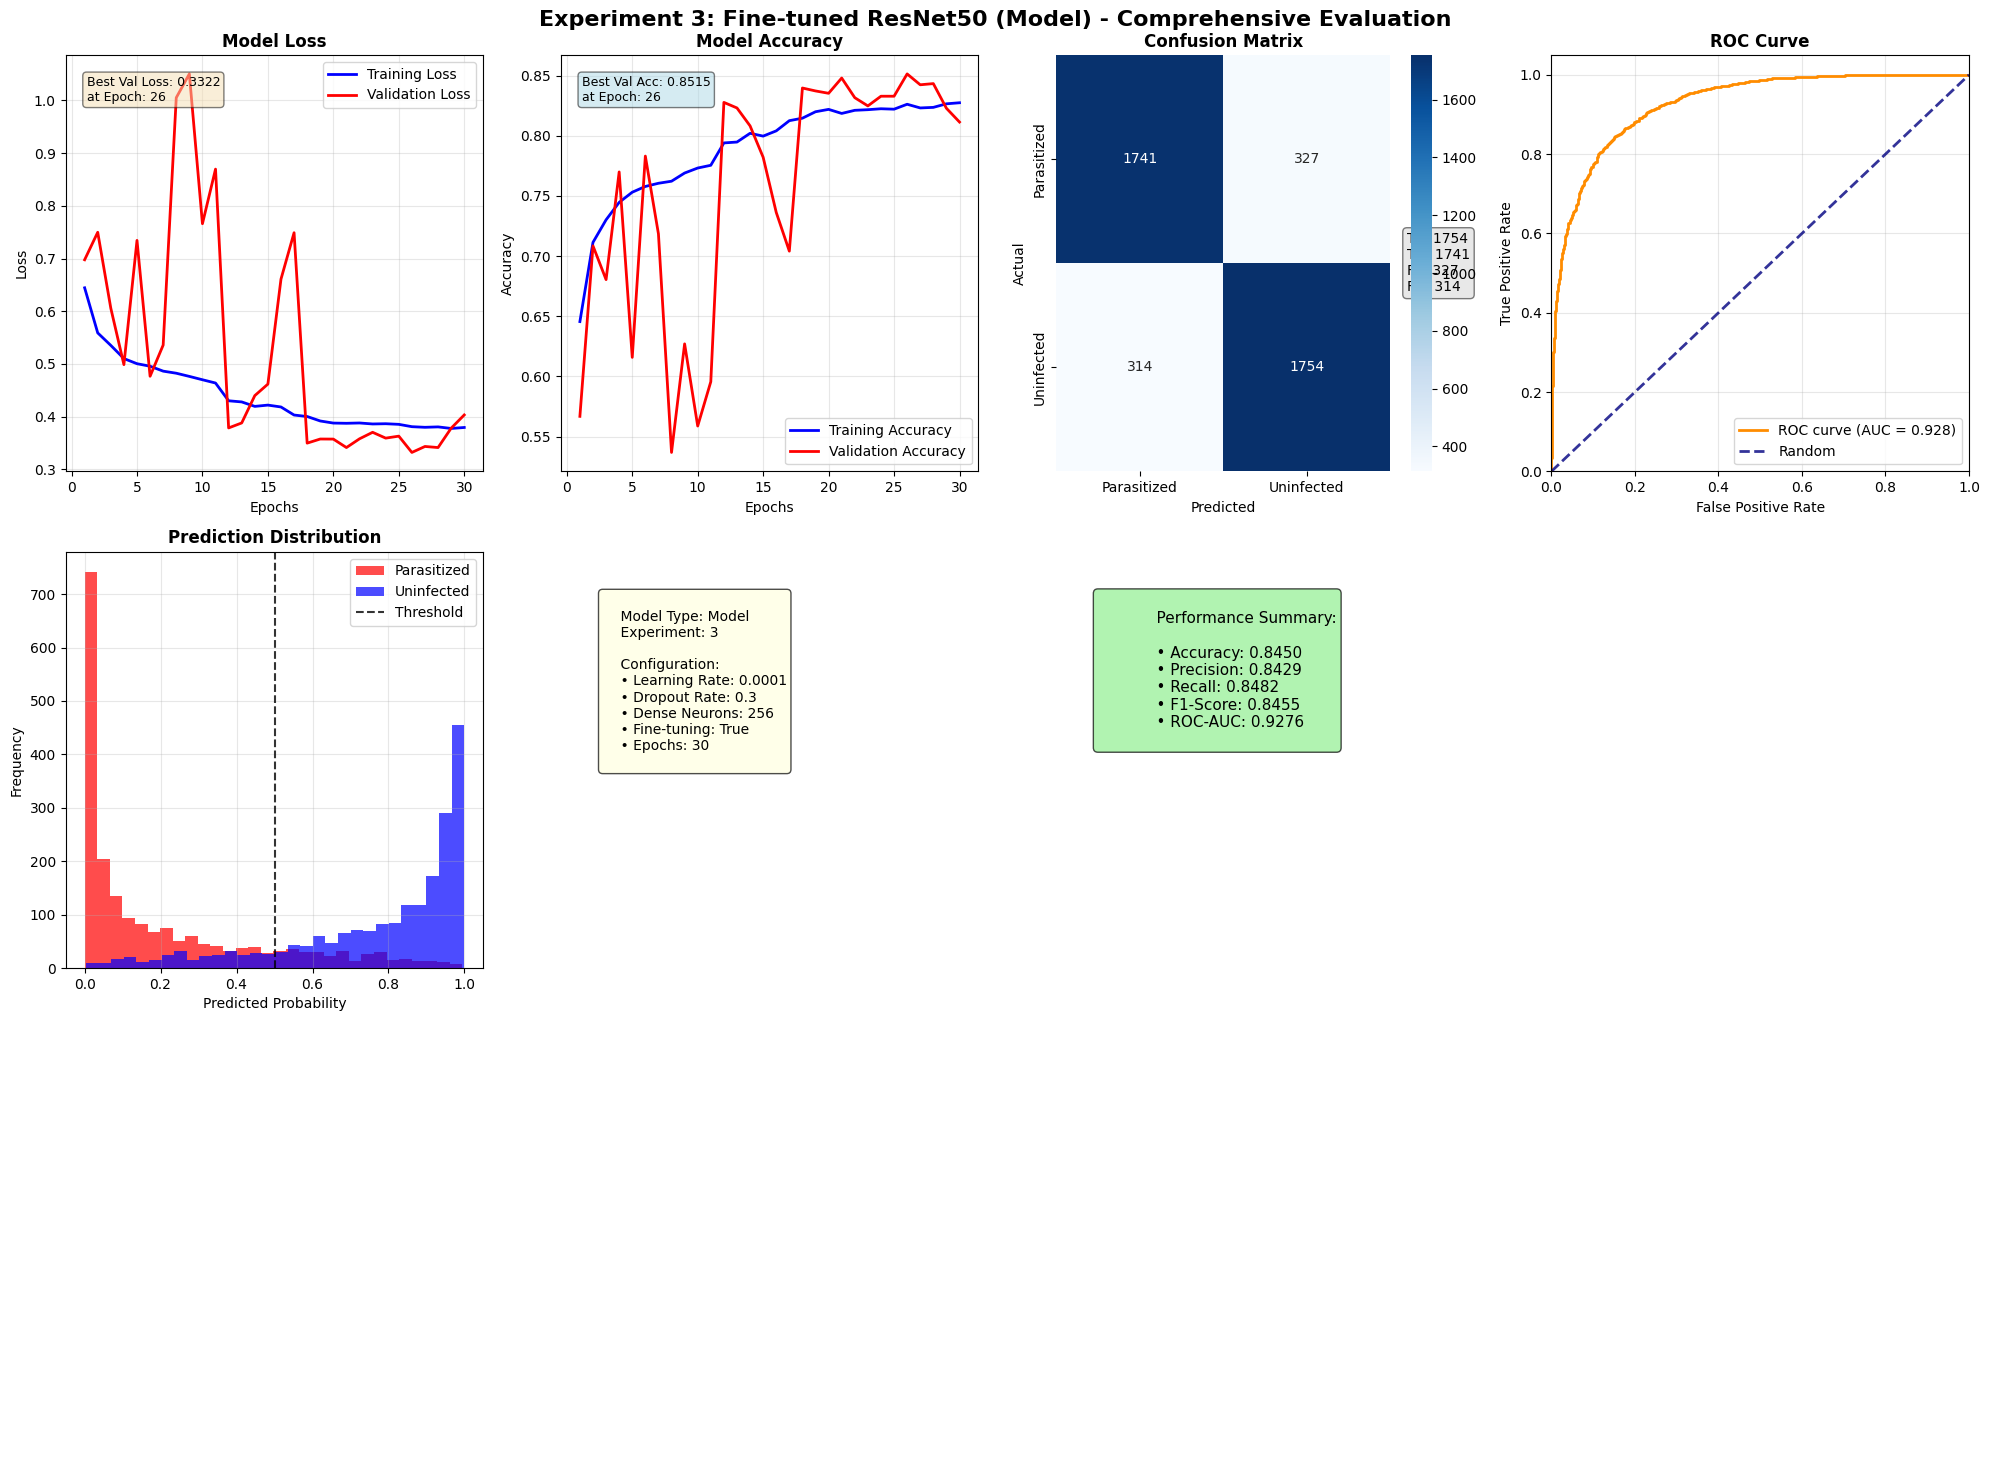

📊 Evaluation plot saved as: Model_Experiment_3:_Fine-tuned_ResNet50_evaluation.png

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.8472    0.8419    0.8445      2068
  Uninfected     0.8429    0.8482    0.8455      2068

    accuracy                         0.8450      4136
   macro avg     0.8450    0.8450    0.8450      4136
weighted avg     0.8450    0.8450    0.8450      4136


 EXPERIMENT 3 SUMMARY:
   Test Accuracy: 0.8450
   F1-Score: 0.8455
   ROC-AUC: 0.9276
   Training Time: 29.30 minutes

📈 CURRENT RANKINGS (by F1-Score):
   3. Experiment 3: Fine-tuned ResNet50 - F1: 0.8455
   1. Experiment 1: Lower Learning Rate - F1: 0.6919
   2. Experiment 2: Larger Dense Layer - F1: 0.6665

 EXPERIMENTAL SUITE COMPLETED!
   Total time: 66.89 minutes
   Successful experiments: 3/3
   Average time per experiment: 22.30 minutes

📊 COMPREHENSIVE COMPARATIVE ANALYSIS

 FINAL PERFORMANCE TABLE (Ranked by F1-Score):
                  

<Figure size 640x480 with 0 Axes>

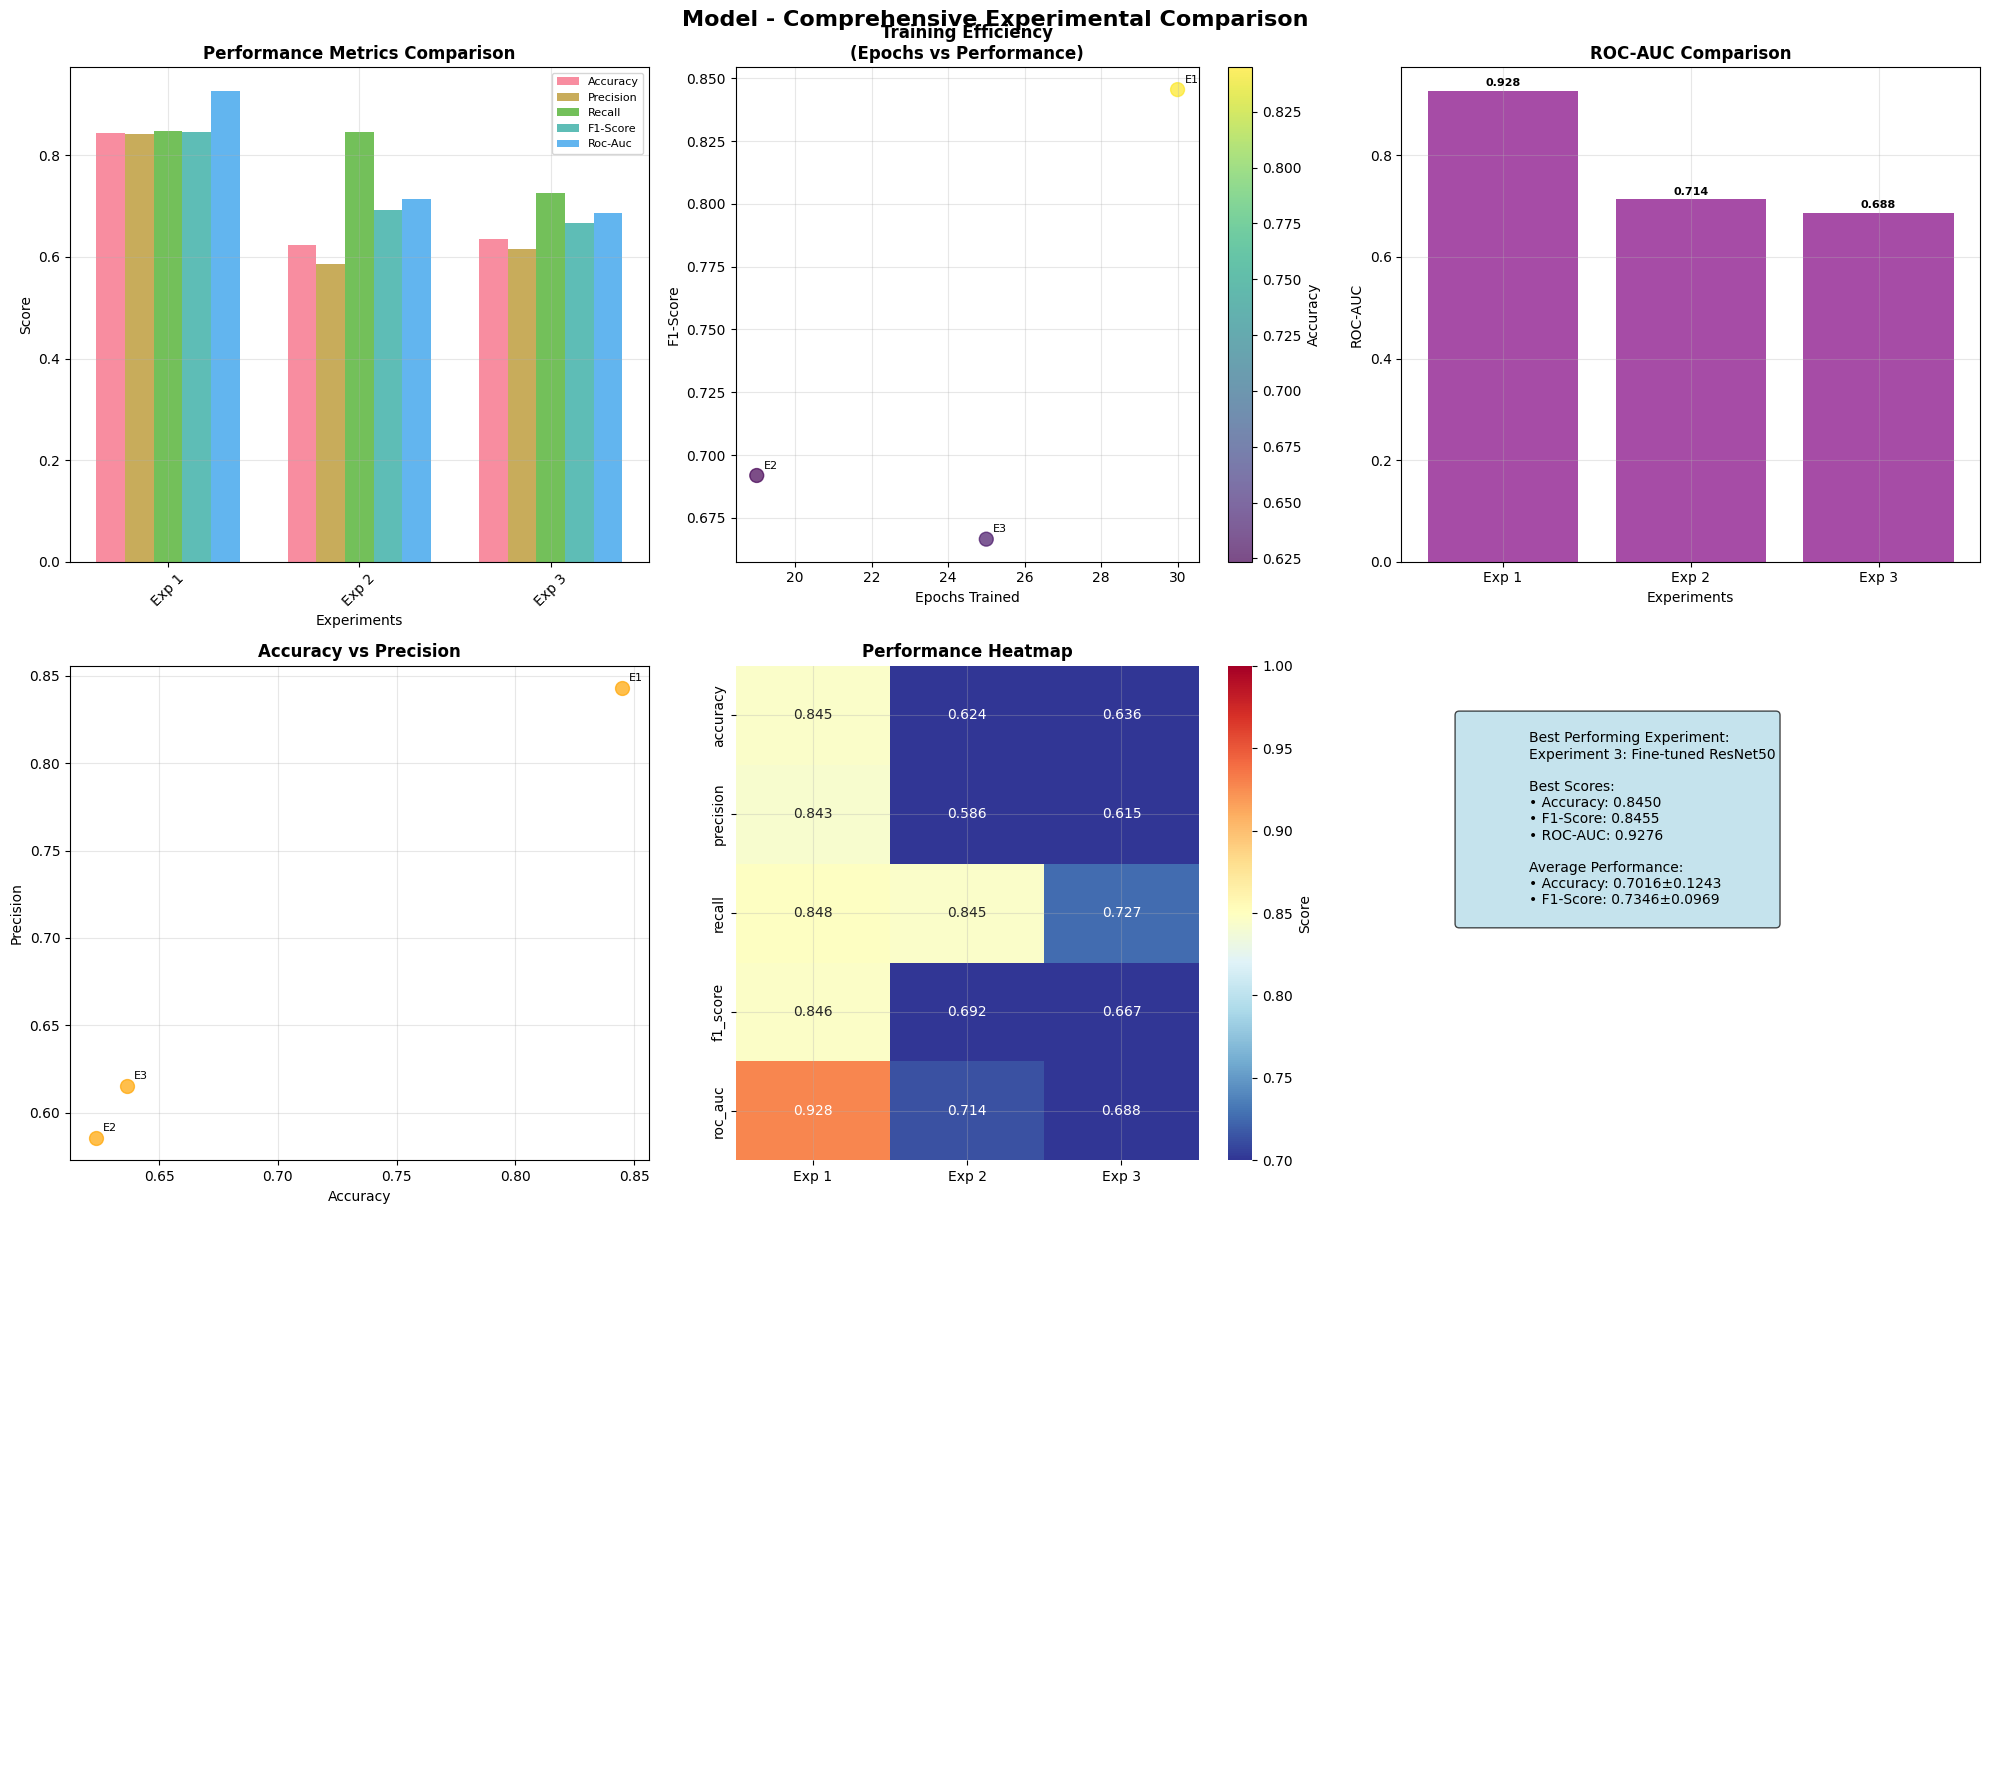

📊 Evaluation plot saved as: Model_comparison_plots.png

🔍 HYPERPARAMETER IMPACT ANALYSIS:

📊 Learning Rate Impact:
   LR   0.0001: F1=0.8455±nan (n=1)
   LR   0.0005: F1=0.6919±nan (n=1)
   LR    0.001: F1=0.6665±nan (n=1)

📊 Dropout Rate Impact:
   Dropout 0.3: F1=0.8455±nan (n=1)
   Dropout 0.5: F1=0.6665±nan (n=1)
   Dropout 0.7: F1=0.6919±nan (n=1)

📊 Dense Layer Size Impact:
   256 neurons: F1=0.7687±0.1086 (n=2)
   512 neurons: F1=0.6665±nan (n=1)

📊 Fine-tuning Impact:
       Frozen: F1=0.6792±0.0179 (n=2)
   Fine-tuned: F1=0.8455±nan (n=1)

💾 EXPORTING MODEL RESULTS:
   📄 CSV exported: Model_experiments_20251005_192721.csv
   📄 JSON exported: Model_detailed_results_20251005_192721.json
   ✅ All Model results successfully exported!
 Ready to start experiments!


<Figure size 640x480 with 0 Axes>

In [ ]:
# START ALL EXPERIMENTS
final_results = run_all_experiments()

print(" Ready to start experiments!")

## 📊 Before vs After Comparison

### ❌ Before (Duplicated Code):
```
📂 Notebook Structure:
├── Data Preprocessing
├── Baseline CNN
├── ResNet50 Section
│   ├── create_resnet_model()
│   ├── evaluate_model_comprehensive()  ← DUPLICATE 1
│   ├── create_evaluation_plots()       ← DUPLICATE 1
│   └── create_final_comparison_plots() ← DUPLICATE 1
└── VGG16 Section  
    ├── create_resnet_model()           ← WRONG NAME! 🚨
    ├── evaluate_model_comprehensive()  ← DUPLICATE 2
    ├── create_evaluation_plots()       ← DUPLICATE 2
    └── create_final_comparison_plots() ← DUPLICATE 2
```

### ✅ After (Refactored Code):
```
📂 Notebook Structure:
├── Data Preprocessing
├── 🔧 Common Functions (NEW!)
│   ├── evaluate_model_comprehensive() ← UNIVERSAL
│   ├── create_evaluation_plots()      ← UNIVERSAL
│   ├── create_final_comparison_plots()← UNIVERSAL
│   ├── analyze_hyperparameter_impact()← UNIVERSAL
│   └── export_results()               ← UNIVERSAL
├── Baseline CNN
├── ResNet50 Section
│   └── create_resnet50_model()        ← MODEL-SPECIFIC
└── VGG16 Section
    └── create_vgg16_model()            ← MODEL-SPECIFIC (FIXED!)
```

## Model training(VGG16) -- Alice Mukarwama






This cell imports the VGG16 model from TensorFlow Keras applications and other libraries needed for comprehensive model evaluation, such as classification reports, confusion matrices, and ROC curves from scikit-learn, along with plotting libraries.

In [ ]:
# Import VGG16 and additional libraries for comprehensive evaluation
from tensorflow.keras.applications import VGG16
import time

print("✓ Additional libraries imported successfully")
print("✓ Ready to build VGG16 transfer learning experiments")

✓ Additional libraries imported successfully
✓ Ready to build VGG16 transfer learning experiments


This cell defines different configurations for training the VGG16 model, each with varying hyperparameters like learning rate, dropout, dense layer size, and whether to fine-tune the base model.

In [ ]:
# Define 3 experimental configurations
experiments = [
    {
        'name': 'Experiment 1: Lower Learning Rate',
        'learning_rate': 0.0005,
        'optimizer': 'adam',
        'dropout_rate': 0.7,
        'dense_neurons': 256,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Reduced learning rate for more stable training and Increased regularization to prevent overfitting'
    },
    {
        'name': 'Experiment 2: Larger Dense Layer',
        'learning_rate': 0.001,
        'optimizer': 'sgd',
        'dropout_rate': 0.5,
        'dense_neurons': 512,
        'epochs': 25,
        'fine_tune': False,
        'description': 'Increased model capacity with more neurons and Alternative optimizer with momentum'
    },
    {
        'name': 'Experiment 3: Fine-tuned VGG16',
        'learning_rate': 0.0001,
        'optimizer': 'adam',
        'dropout_rate': 0.3,
        'dense_neurons': 256,
        'epochs': 30,
        'fine_tune': True,
        'description': 'Unfrozen top layers for fine-tuning'
    }
]

print(f"✓ Defined {len(experiments)} experimental configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"  {i}. {exp['name']}")
    print(f"     {exp['description']}")

# Global variables to store results
experiment_results = []
all_histories = []

✓ Defined 3 experimental configurations:
  1. Experiment 1: Lower Learning Rate
     Reduced learning rate for more stable training and Increased regularization to prevent overfitting
  2. Experiment 2: Larger Dense Layer
     Increased model capacity with more neurons and Alternative optimizer with momentum
  3. Experiment 3: Fine-tuned VGG16
     Unfrozen top layers for fine-tuning


This function creates a VGG16 transfer learning model based on the provided configuration, allowing for freezing or fine-tuning the base model and adding custom layers for classification.

In [ ]:
# Function to create VGG16 transfer learning model
def create_vgg16_model(config):
    """
    Create a VGG16 transfer learning model with specified configuration

    Args:
        config: Dictionary containing model configuration parameters

    Returns:
        Compiled Keras model
    """
    print(f"\n Building model: {config['name']}")
    print(f"   Configuration: LR={config['learning_rate']}, Dropout={config['dropout_rate']}, "
          f"Dense={config['dense_neurons']}, Fine-tune={config['fine_tune']}")

    # Clear any previous models from memory
    tf.keras.backend.clear_session()

    # Load pre-trained VGG16 base
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Configure base model trainability
    if config['fine_tune']:
        # Freeze early layers, allow fine-tuning of later layers
        base_model.trainable = True
        # Freeze the first 100 layers (out of 175 total)
        for layer in base_model.layers[:100]:
            layer.trainable = False
        print(f"   Fine-tuning enabled: {len([l for l in base_model.layers if l.trainable])} trainable layers")
    else:
        # Freeze all layers in base model
        base_model.trainable = False
        print(f"   Base model frozen: {len(base_model.layers)} layers")

    # Build the complete model
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(config['dense_neurons'], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Configure optimizer
    if config['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=config['learning_rate'],
            momentum=0.9
        )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"   Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"   Trainable parameters: {trainable_params:,}")

    return model

print("✓ VGG16 model creation function defined")

✓ VGG16 model creation function defined


This function runs a single experiment based on a given configuration, including building, training, and evaluating the model with specified callbacks.

In [ ]:
# Function to run a single experiment
def run_single_experiment(config, exp_number, total_experiments):
    """
    Run a single experiment with comprehensive evaluation

    Args:
        config: Experiment configuration dictionary
        exp_number: Current experiment number
        total_experiments: Total number of experiments

    Returns:
        Dictionary containing experiment results
    """
    print(f"\n {'='*80}")
    print(f"EXPERIMENT {exp_number}/{total_experiments}: {config['name']}")
    print(f"{'='*80}")
    print(f"Description: {config['description']}")
    print(f"⏰ Started at: {datetime.now().strftime('%H:%M:%S')}")

    start_time = datetime.now()

    try:
        # Create model
        model = create_vgg16_model(config)

        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]

        print(f"\n Training model for up to {config['epochs']} epochs...")

        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=config['epochs'],
            validation_data=validation_generator,
            validation_steps=VALIDATION_STEPS,
            callbacks=callbacks,
            verbose=1
        )

        end_time = datetime.now()
        training_duration = (end_time - start_time).total_seconds() / 60

        print(f"\n✅ Training completed in {training_duration:.2f} minutes")
        print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
        print(f"   Epochs trained: {len(history.history['loss'])}")

        # Comprehensive evaluation
        results = evaluate_model_comprehensive(model, history, config, exp_number)
        results['training_duration_minutes'] = training_duration

        # Store results and history
        experiment_results.append(results)
        all_histories.append({
            'experiment': config['name'],
            'history': history.history,
            'config': config.copy()
        })

        print(f"\n EXPERIMENT {exp_number} SUMMARY:")
        print(f"   Test Accuracy: {results['accuracy']:.4f}")
        print(f"   F1-Score: {results['f1_score']:.4f}")
        print(f"   ROC-AUC: {results['roc_auc']:.4f}")
        print(f"   Training Time: {training_duration:.2f} minutes")

        # Clean up memory
        del model
        gc.collect()

        return results

    except Exception as e:
        print(f"\n❌ ERROR in {config['name']}: {str(e)}")
        print(f"Skipping to next experiment...")
        return None

print("✓ Single experiment runner function defined")

✓ Single experiment runner function defined


This function orchestrates the execution of all VGG16 experiments defined in the configuration. It iterates through each experiment, runs them sequentially, collects results, and generates comparative visualizations and analysis across all experiments.

In [ ]:
# MAIN EXPERIMENTAL SUITE FUNCTIONS

# Function to run all experiments and generate comparative analysis
def run_all_experiments():
    """
    Run all 7 experiments sequentially and generate comprehensive comparative analysis
    """
    print(f"\n STARTING RESNET50 EXPERIMENTAL SUITE")
    print(f"{'='*100}")
    print(f"📊 Total experiments to run: {len(experiments)}")
    print(f"🕐 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💾 Results will be automatically saved and compared")

    suite_start_time = datetime.now()
    successful_experiments = 0

    # Run each experiment
    for i, config in enumerate(experiments, 1):
        result = run_single_experiment(config, i, len(experiments))
        if result is not None:
            successful_experiments += 1

            # Show intermediate rankings
            if successful_experiments > 1:
                print(f"\n📈 CURRENT RANKINGS (by F1-Score):")
                temp_df = pd.DataFrame(experiment_results).sort_values('f1_score', ascending=False)
                for idx, row in temp_df.head(3).iterrows():
                    print(f"   {idx+1}. {row['experiment']} - F1: {row['f1_score']:.4f}")

        # Estimate remaining time
        if i < len(experiments):
            elapsed = (datetime.now() - suite_start_time).total_seconds() / 60
            estimated_remaining = (elapsed / i) * (len(experiments) - i)
            print(f"\n⏱️  Progress: {i}/{len(experiments)} | Estimated time remaining: {estimated_remaining:.1f} minutes")

    suite_end_time = datetime.now()
    total_duration = (suite_end_time - suite_start_time).total_seconds() / 60

    print(f"\n EXPERIMENTAL SUITE COMPLETED!")
    print(f"   Total time: {total_duration:.2f} minutes")
    print(f"   Successful experiments: {successful_experiments}/{len(experiments)}")
    if successful_experiments > 0:
        print(f"   Average time per experiment: {total_duration/successful_experiments:.2f} minutes")

    # Generate comprehensive comparative analysis
    if successful_experiments > 0:
        return generate_final_comparative_analysis()
    else:
        print("❌ No successful experiments to analyze.")
        return None

def generate_final_comparative_analysis():
    """
    Generate comprehensive comparative analysis across all experiments
    """
    if not experiment_results:
        print("No experiment results to analyze.")
        return None

    print(f"\n{'='*100}")
    print(f"📊 COMPREHENSIVE COMPARATIVE ANALYSIS")
    print(f"{'='*100}")

    # Create results DataFrame
    df_results = pd.DataFrame(experiment_results)
    df_results = df_results.sort_values('f1_score', ascending=False).reset_index(drop=True)

    # Display performance table
    print(f"\n FINAL PERFORMANCE TABLE (Ranked by F1-Score):")
    print("="*120)

    display_columns = ['experiment', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_duration_minutes']
    display_df = df_results[display_columns].copy()
    display_df.columns = ['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Time (min)']

    # Format numeric columns
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    display_df['Time (min)'] = display_df['Time (min)'].apply(lambda x: f"{x:.1f}")

    print(display_df.to_string(index=False))

    # Statistical analysis
    print(f"\n📈 STATISTICAL SUMMARY:")
    print(f"   Mean Accuracy: {df_results['accuracy'].mean():.4f} ± {df_results['accuracy'].std():.4f}")
    print(f"   Mean F1-Score: {df_results['f1_score'].mean():.4f} ± {df_results['f1_score'].std():.4f}")
    print(f"   Mean ROC-AUC: {df_results['roc_auc'].mean():.4f} ± {df_results['roc_auc'].std():.4f}")
    print(f"   Total Training Time: {df_results['training_duration_minutes'].sum():.1f} minutes")

    # Best and worst performers
    best_exp = df_results.iloc[0]
    worst_exp = df_results.iloc[-1]

    print(f"\n🥇 BEST PERFORMER:")
    print(f"   {best_exp['experiment']}")
    print(f"   F1-Score: {best_exp['f1_score']:.4f} | Accuracy: {best_exp['accuracy']:.4f} | ROC-AUC: {best_exp['roc_auc']:.4f}")
    print(f"   Configuration: {best_exp['config']}")

    print(f"\n LOWEST PERFORMER:")
    print(f"   {worst_exp['experiment']}")
    print(f"   F1-Score: {worst_exp['f1_score']:.4f} | Accuracy: {worst_exp['accuracy']:.4f} | ROC-AUC: {worst_exp['roc_auc']:.4f}")

    # Create comprehensive comparison visualizations
    create_final_comparison_plots(df_results)

    # Hyperparameter analysis
    analyze_hyperparameter_impact(df_results)

    # Export results
    export_results(df_results)

    return df_results

print("✓ Main experimental suite functions defined and ready to use!")

✓ Main experimental suite functions defined and ready to use!


Executing all 3 experiments and generate a comprehensive comparative analysis of their results.


 STARTING RESNET50 EXPERIMENTAL SUITE
📊 Total experiments to run: 3
🕐 Started at: 2025-10-05 19:27:21
💾 Results will be automatically saved and compared

EXPERIMENT 1/3: Experiment 1: Lower Learning Rate
Description: Reduced learning rate for more stable training and Increased regularization to prevent overfitting
⏰ Started at: 19:27:21

 Building model: Experiment 1: Lower Learning Rate
   Configuration: LR=0.0005, Dropout=0.7, Dense=256, Fine-tune=False
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   Base model frozen: 19 layers
   Total parameters: 14,846,273
   Trainable parameters: 131,585

 Training model for up to 25 epochs...
Epoch 1/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.7553 - loss: 0.4853 - val_accuracy: 0.8934 - val_loss: 0.2619 - learning_rate: 5.0000e-04
Epoch 2/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.8771 - loss: 0.3028 - val_accuracy: 0.9139 - val_loss: 0.2261 - learning_rate: 5.0000e-04
Epoch 3/25
602/602 ━━━━━━━━━━━━━━━━

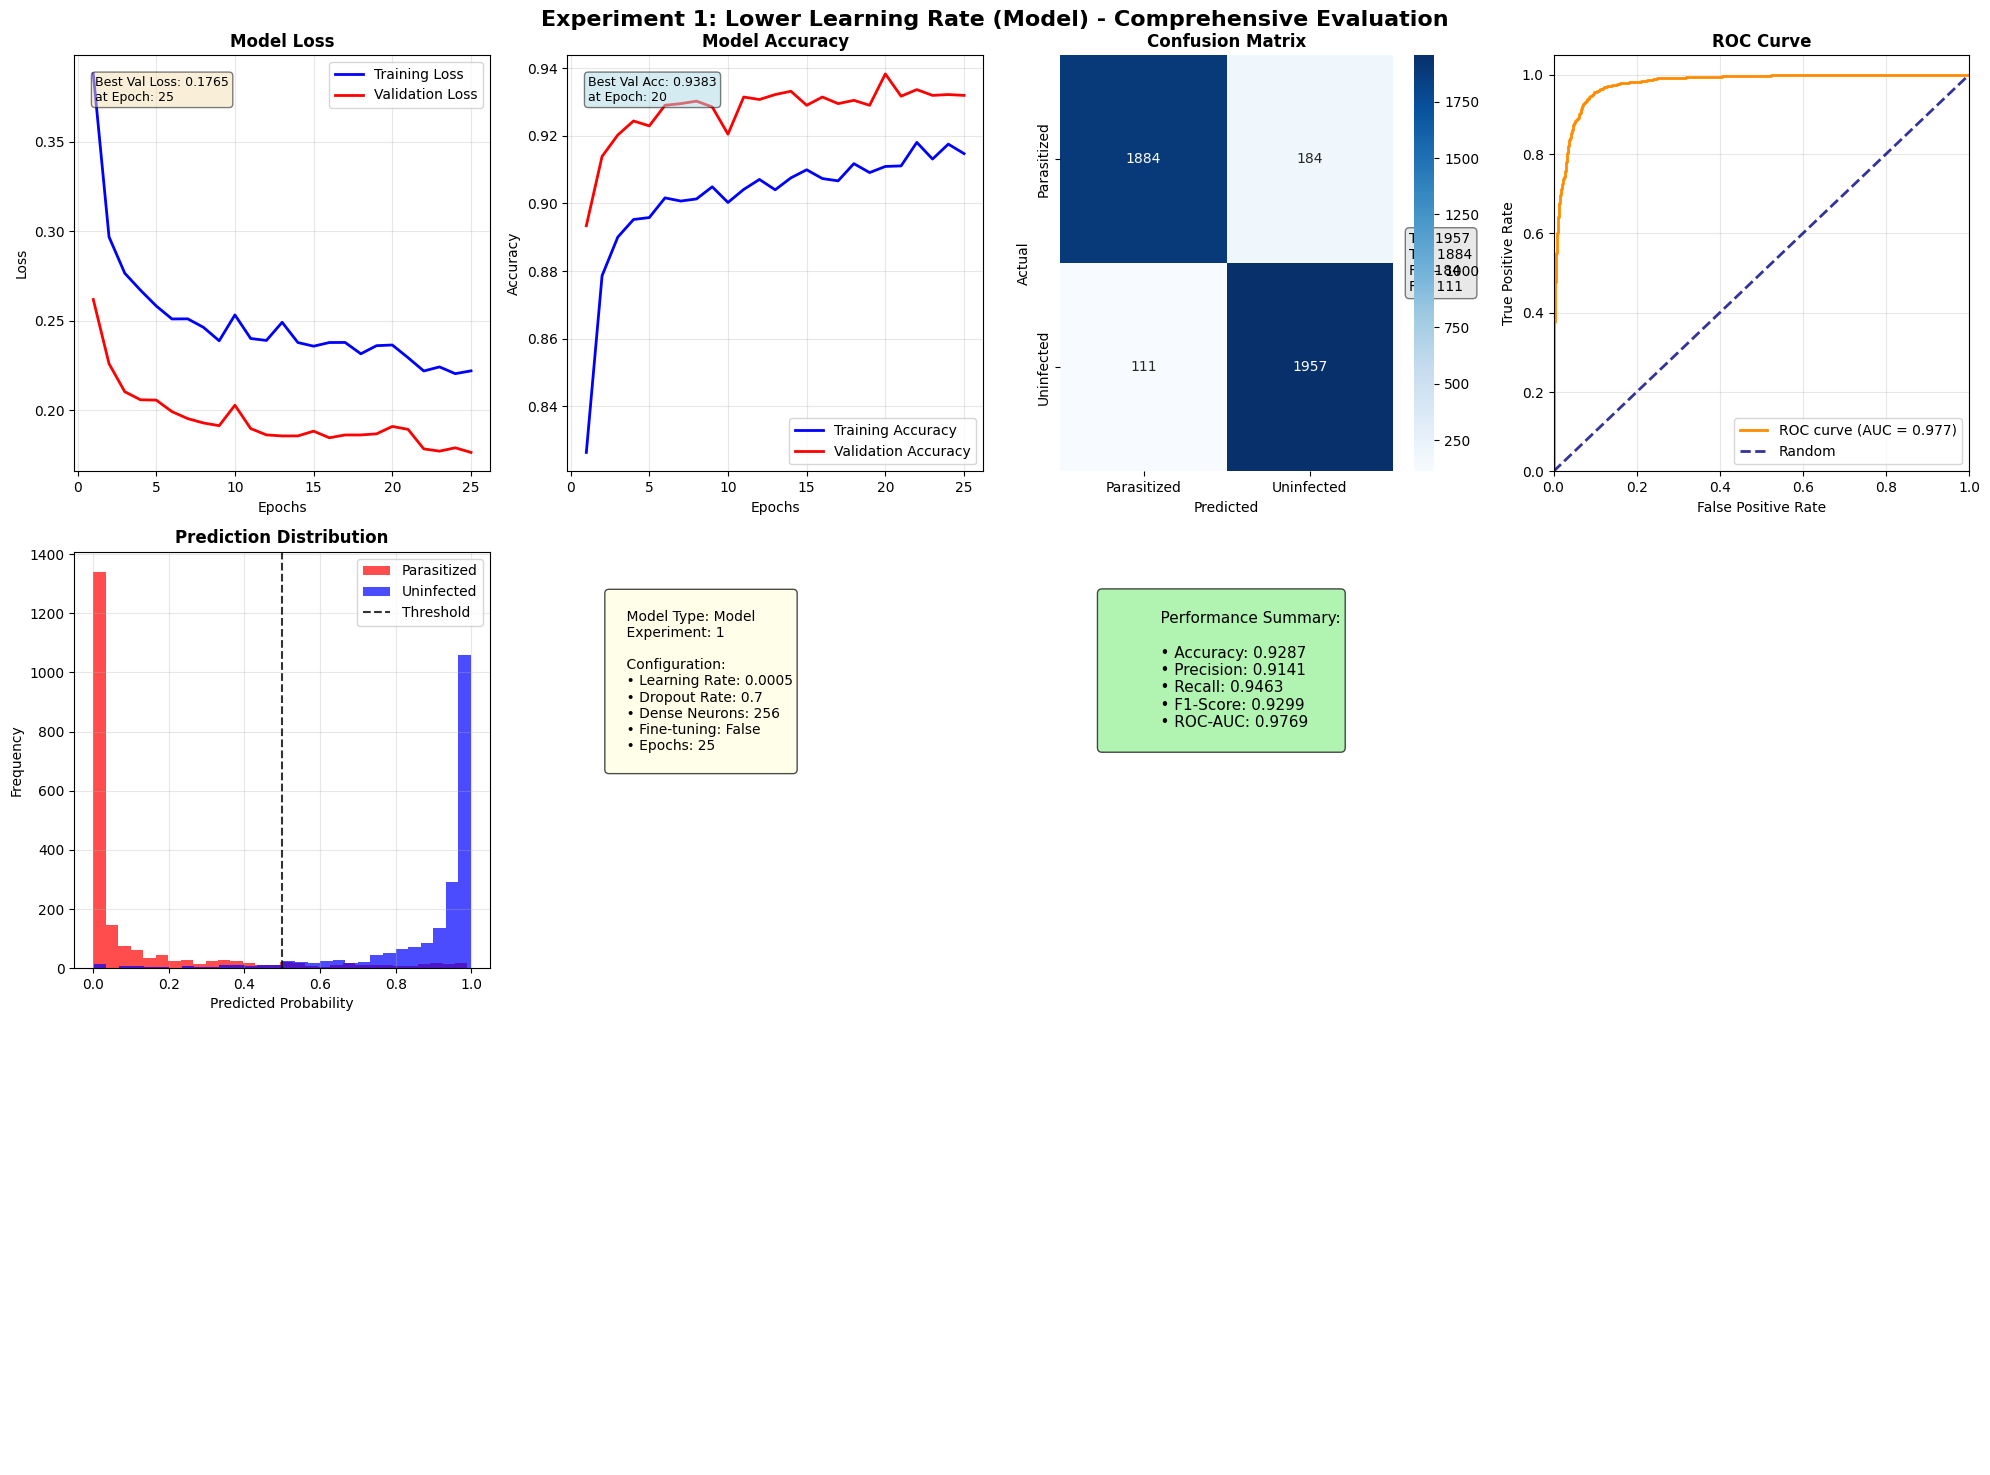

📊 Evaluation plot saved as: Model_Experiment_1:_Lower_Learning_Rate_evaluation.png

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.9444    0.9110    0.9274      2068
  Uninfected     0.9141    0.9463    0.9299      2068

    accuracy                         0.9287      4136
   macro avg     0.9292    0.9287    0.9287      4136
weighted avg     0.9292    0.9287    0.9287      4136


 EXPERIMENT 1 SUMMARY:
   Test Accuracy: 0.9287
   F1-Score: 0.9299
   ROC-AUC: 0.9769
   Training Time: 22.20 minutes

⏱️  Progress: 1/3 | Estimated time remaining: 44.7 minutes

EXPERIMENT 2/3: Experiment 2: Larger Dense Layer
Description: Increased model capacity with more neurons and Alternative optimizer with momentum
⏰ Started at: 19:49:41

 Building model: Experiment 2: Larger Dense Layer
   Configuration: LR=0.001, Dropout=0.5, Dense=512, Fine-tune=False
   Base model frozen: 19 layers
   Total parameters: 14,977,857
   Trainable parameters

<Figure size 640x480 with 0 Axes>

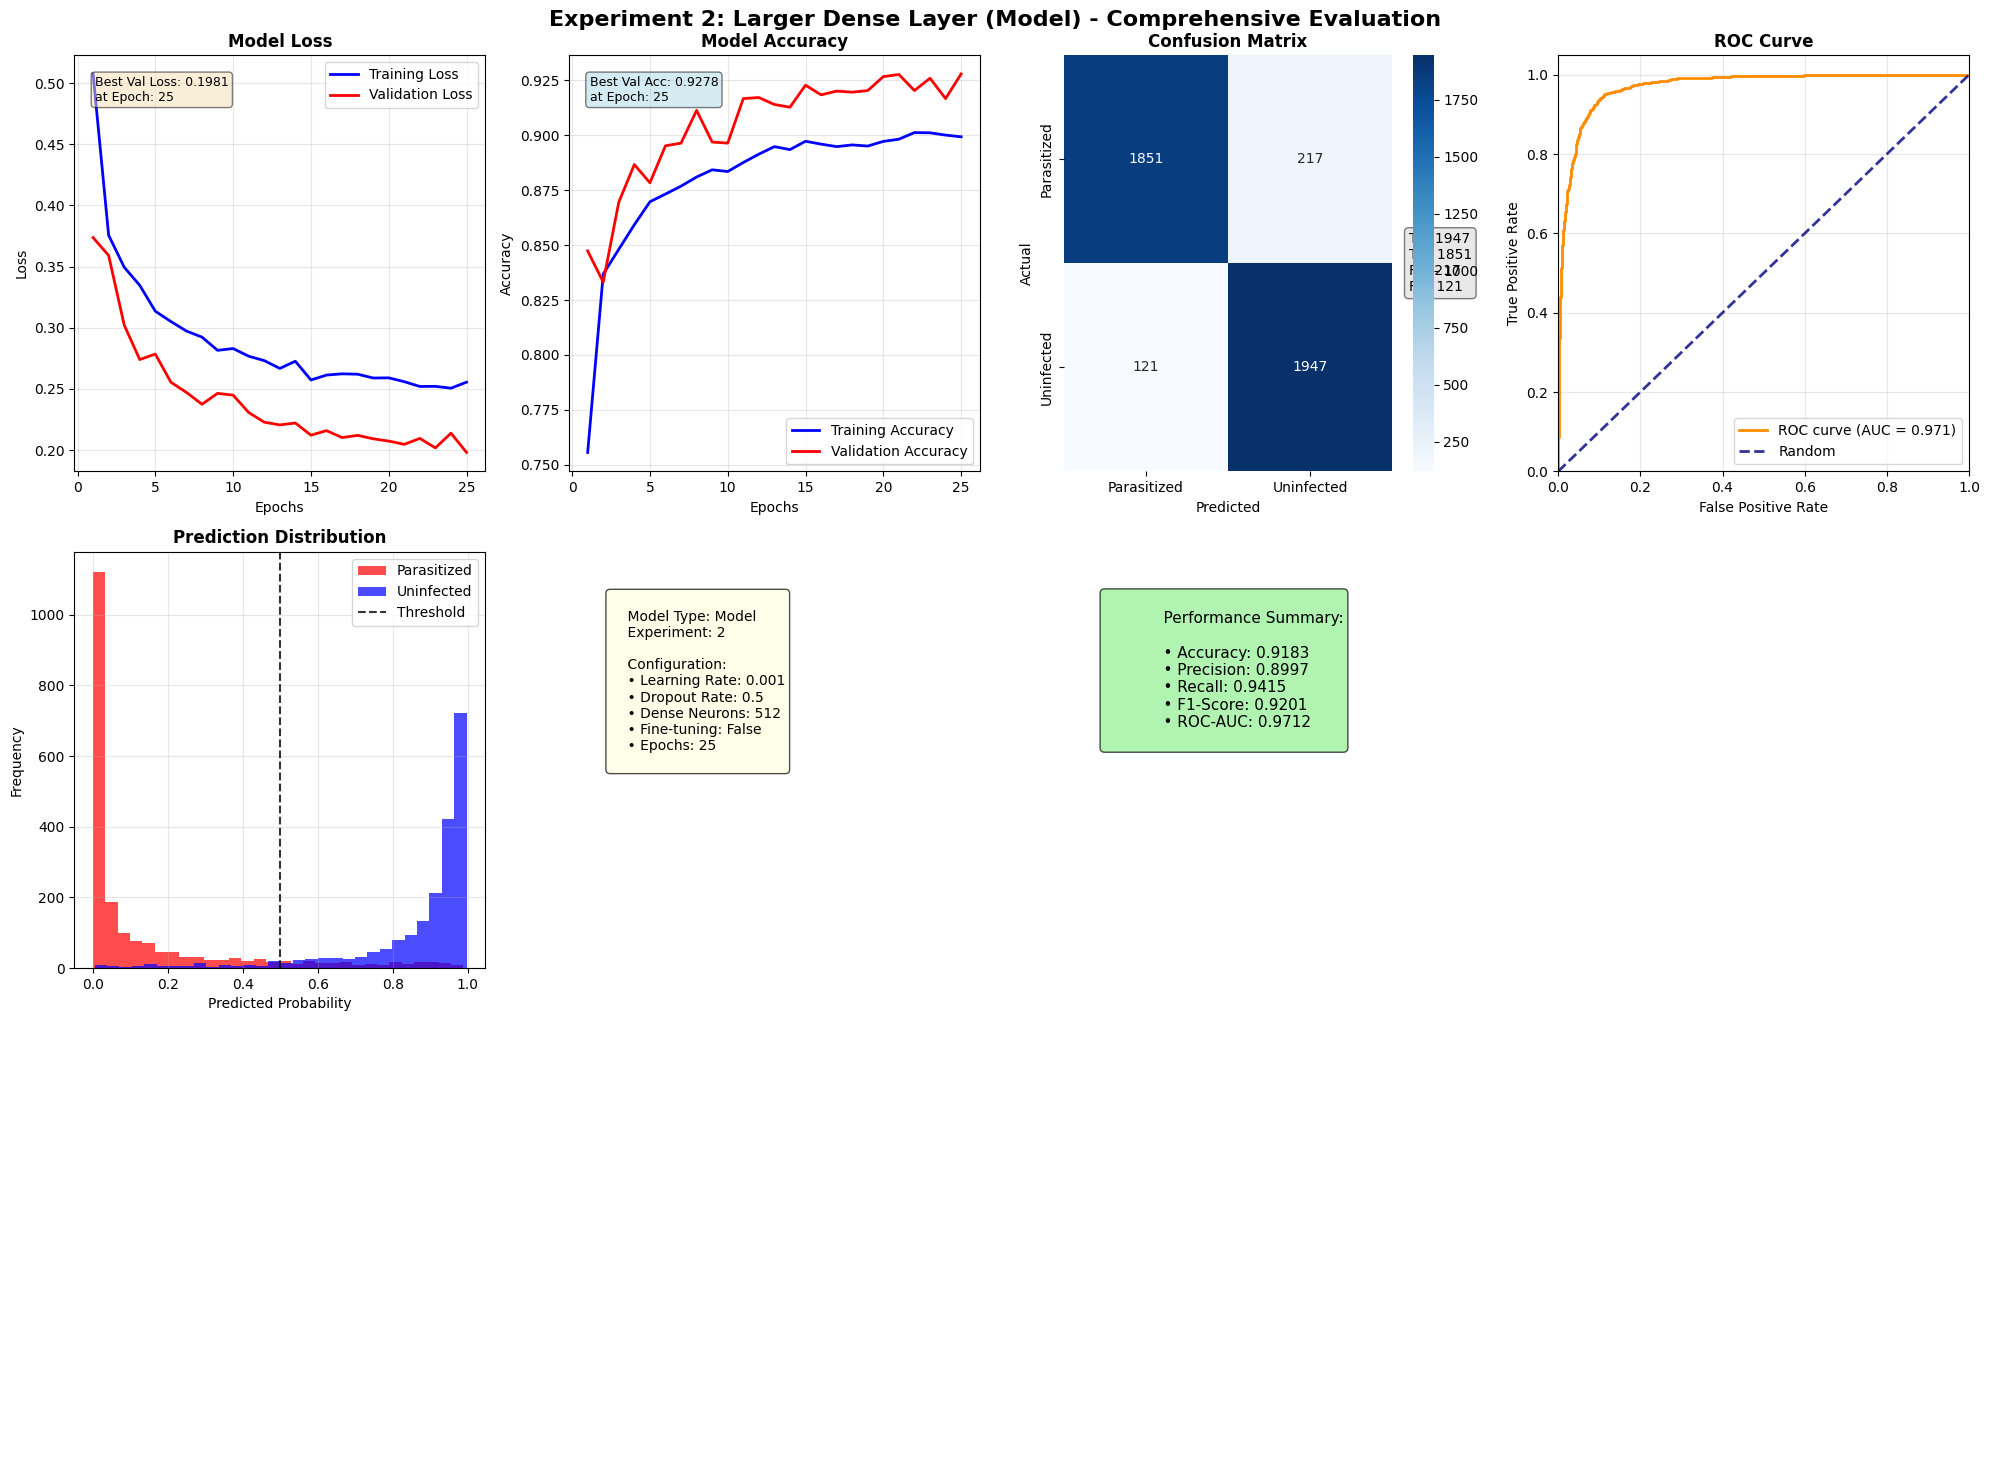

📊 Evaluation plot saved as: Model_Experiment_2:_Larger_Dense_Layer_evaluation.png

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.9386    0.8951    0.9163      2068
  Uninfected     0.8997    0.9415    0.9201      2068

    accuracy                         0.9183      4136
   macro avg     0.9192    0.9183    0.9182      4136
weighted avg     0.9192    0.9183    0.9182      4136


 EXPERIMENT 2 SUMMARY:
   Test Accuracy: 0.9183
   F1-Score: 0.9201
   ROC-AUC: 0.9712
   Training Time: 22.69 minutes

📈 CURRENT RANKINGS (by F1-Score):
   1. Experiment 1: Lower Learning Rate - F1: 0.9299
   2. Experiment 2: Larger Dense Layer - F1: 0.9201

⏱️  Progress: 2/3 | Estimated time remaining: 22.6 minutes

EXPERIMENT 3/3: Experiment 3: Fine-tuned VGG16
Description: Unfrozen top layers for fine-tuning
⏰ Started at: 20:12:30

 Building model: Experiment 3: Fine-tuned VGG16
   Configuration: LR=0.0001, Dropout=0.3, Dense=256, Fine-tune=True

<Figure size 640x480 with 0 Axes>

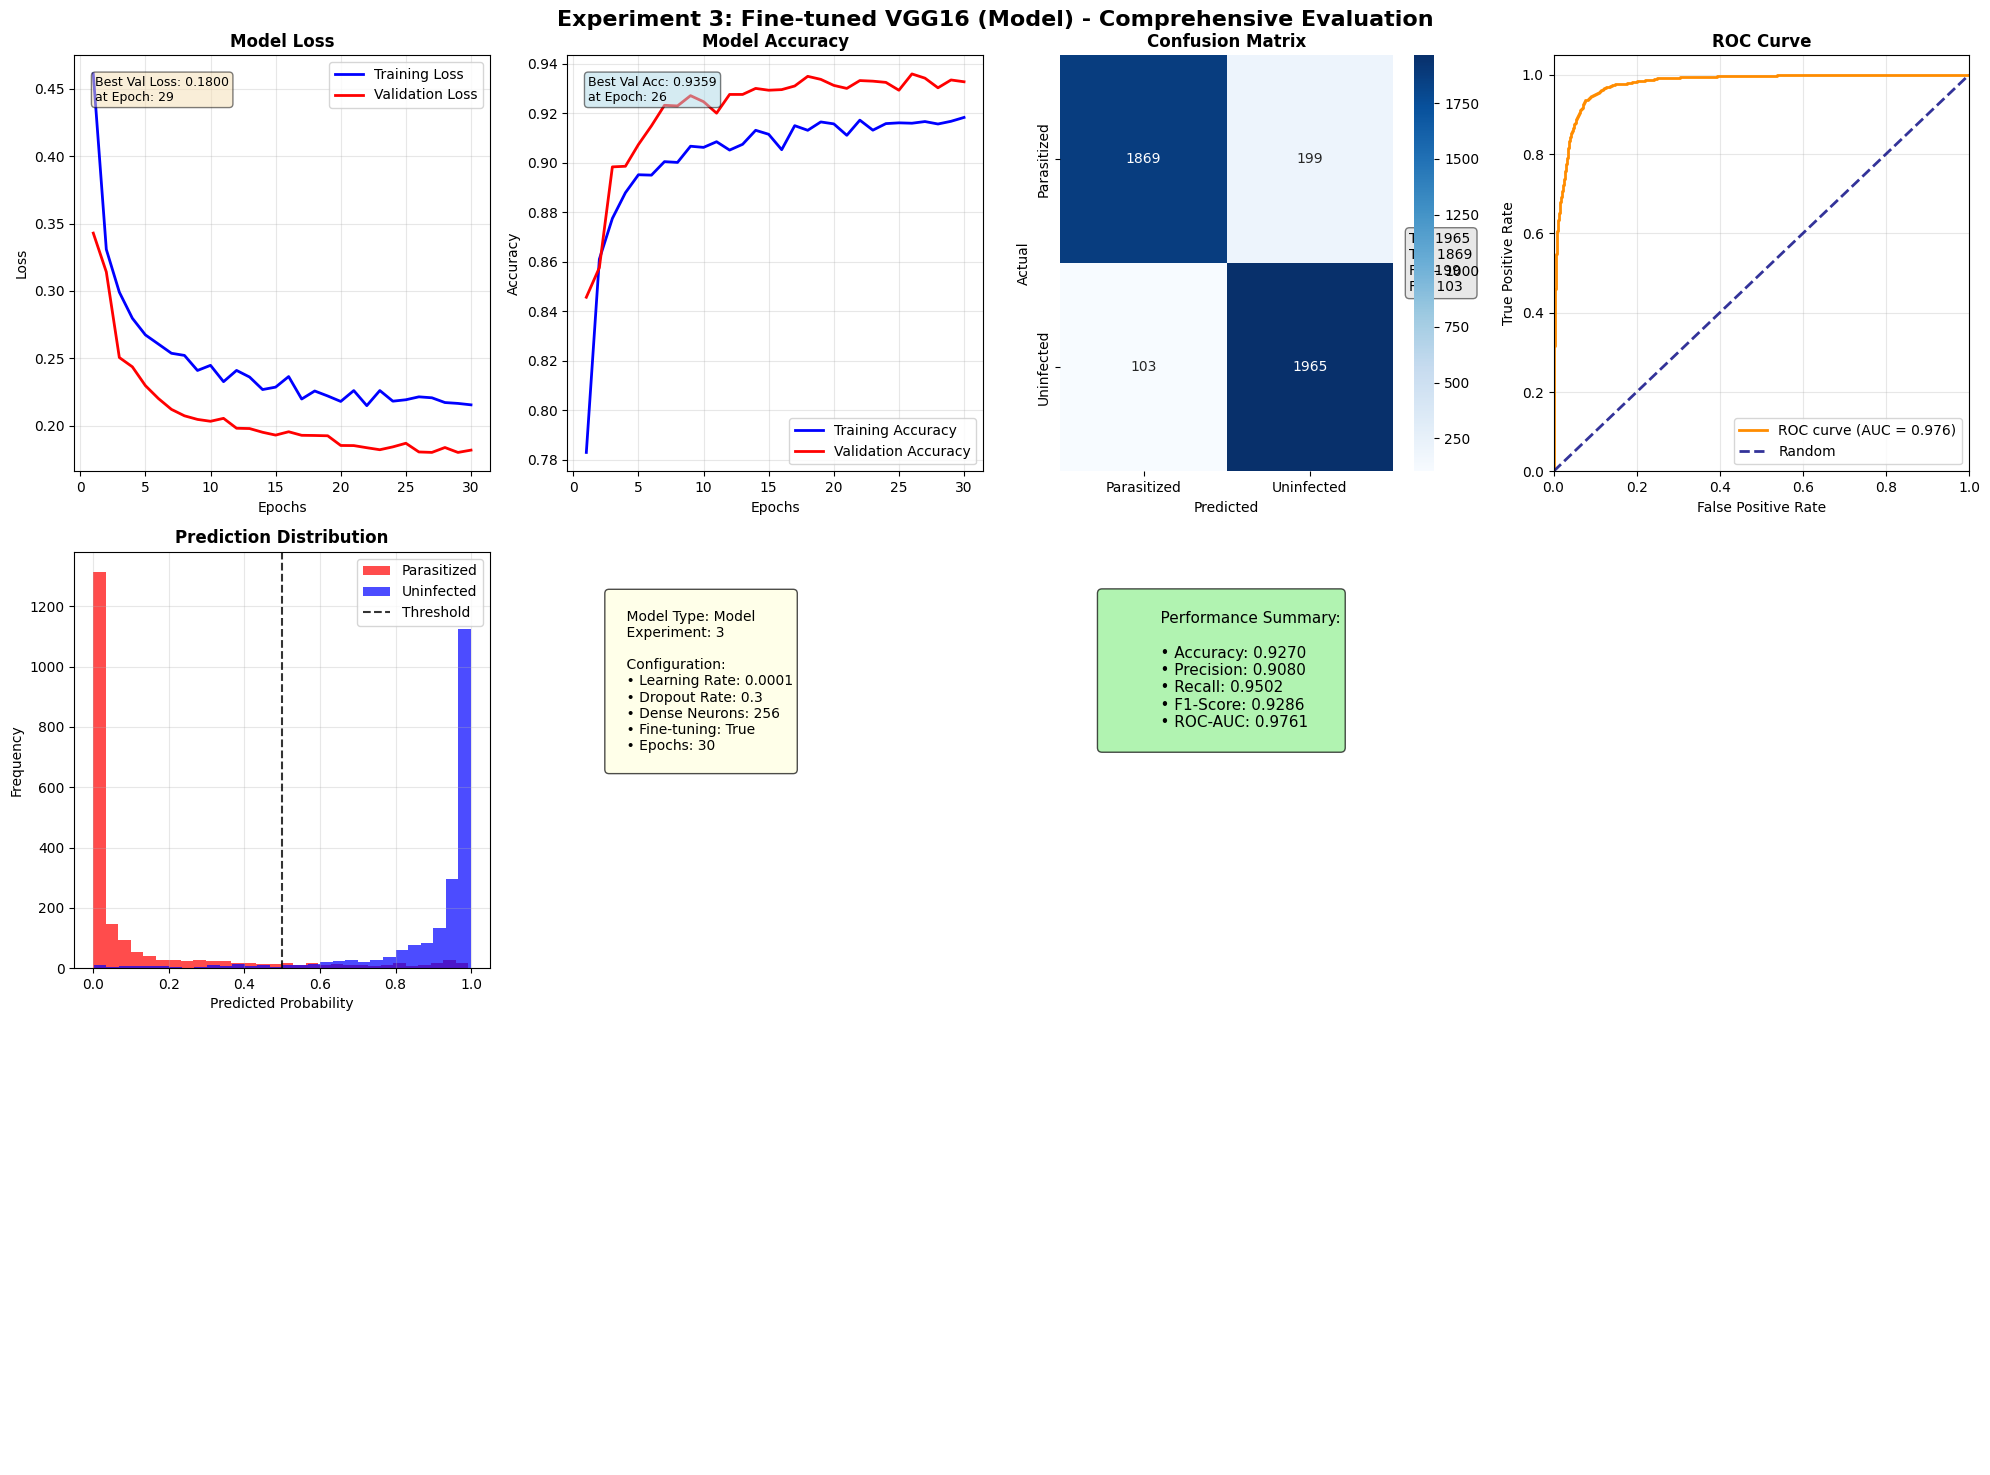

📊 Evaluation plot saved as: Model_Experiment_3:_Fine-tuned_VGG16_evaluation.png

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Parasitized     0.9478    0.9038    0.9252      2068
  Uninfected     0.9080    0.9502    0.9286      2068

    accuracy                         0.9270      4136
   macro avg     0.9279    0.9270    0.9269      4136
weighted avg     0.9279    0.9270    0.9269      4136


 EXPERIMENT 3 SUMMARY:
   Test Accuracy: 0.9270
   F1-Score: 0.9286
   ROC-AUC: 0.9761
   Training Time: 26.25 minutes

📈 CURRENT RANKINGS (by F1-Score):
   1. Experiment 1: Lower Learning Rate - F1: 0.9299
   3. Experiment 3: Fine-tuned VGG16 - F1: 0.9286
   2. Experiment 2: Larger Dense Layer - F1: 0.9201

 EXPERIMENTAL SUITE COMPLETED!
   Total time: 71.53 minutes
   Successful experiments: 3/3
   Average time per experiment: 23.84 minutes

📊 COMPREHENSIVE COMPARATIVE ANALYSIS

 FINAL PERFORMANCE TABLE (Ranked by F1-Score):
                       E

<Figure size 640x480 with 0 Axes>

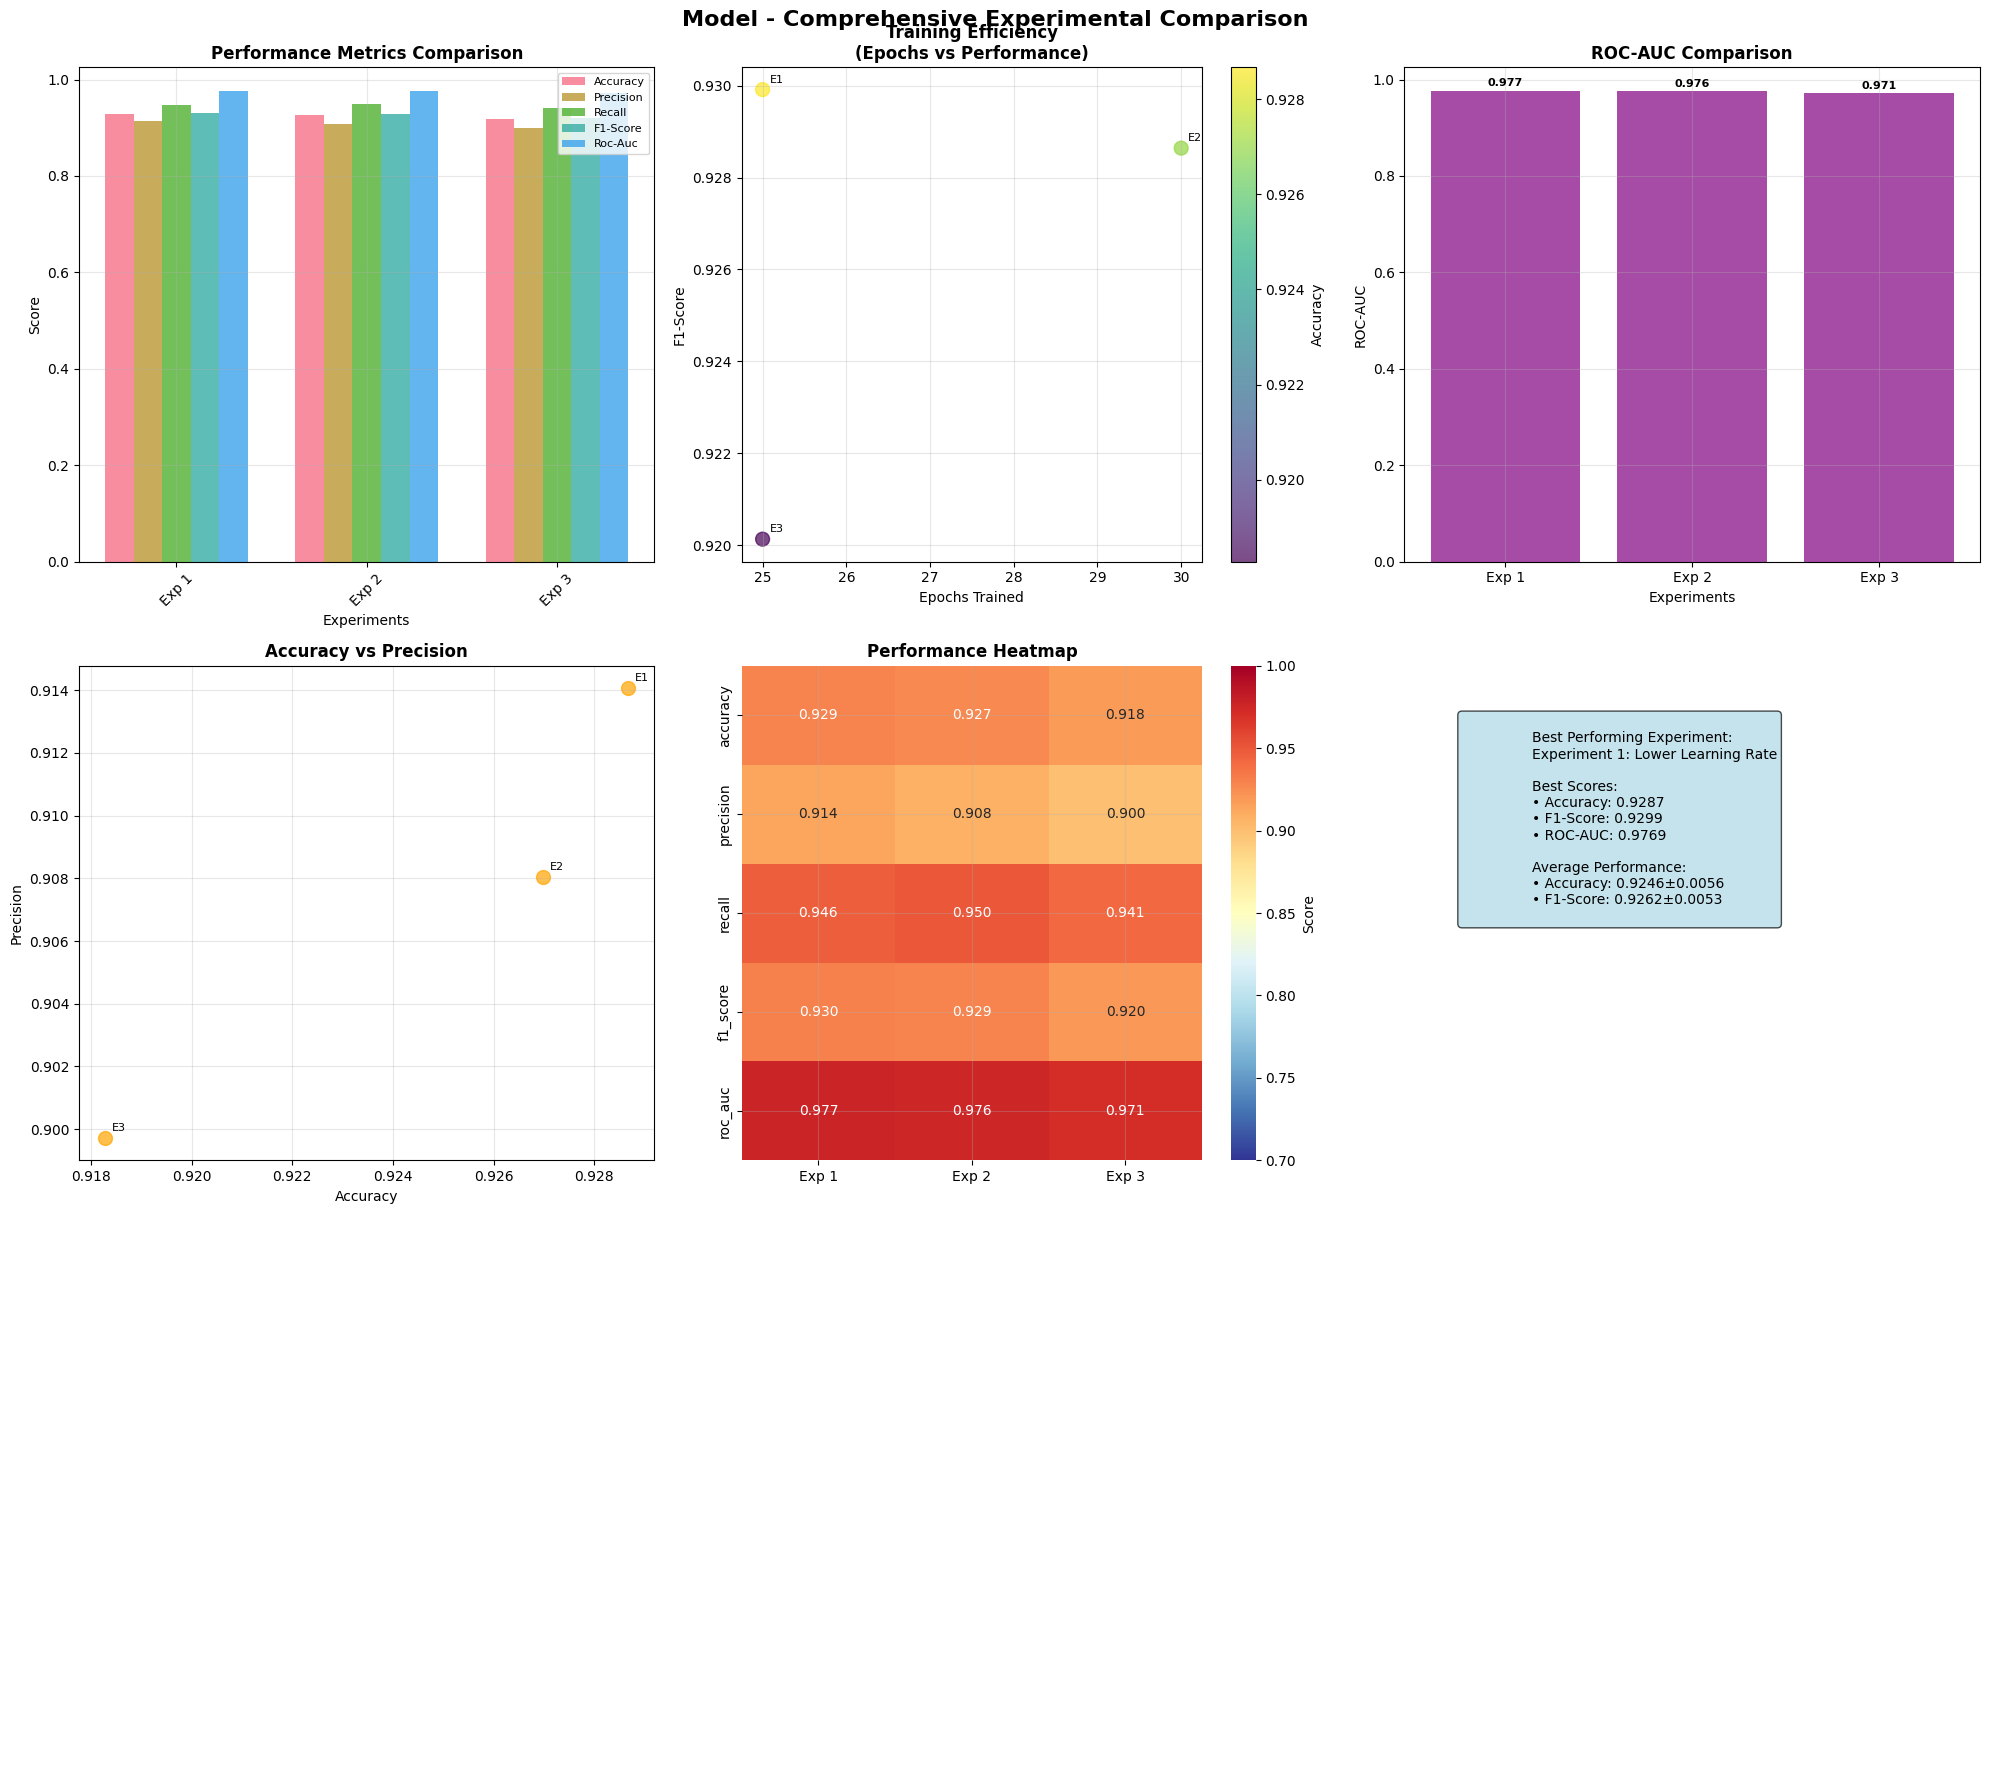

📊 Evaluation plot saved as: Model_comparison_plots.png

🔍 HYPERPARAMETER IMPACT ANALYSIS:

📊 Learning Rate Impact:
   LR   0.0001: F1=0.9286±nan (n=1)
   LR   0.0005: F1=0.9299±nan (n=1)
   LR    0.001: F1=0.9201±nan (n=1)

📊 Dropout Rate Impact:
   Dropout 0.3: F1=0.9286±nan (n=1)
   Dropout 0.5: F1=0.9201±nan (n=1)
   Dropout 0.7: F1=0.9299±nan (n=1)

📊 Dense Layer Size Impact:
   256 neurons: F1=0.9293±0.0009 (n=2)
   512 neurons: F1=0.9201±nan (n=1)

📊 Fine-tuning Impact:
       Frozen: F1=0.9250±0.0069 (n=2)
   Fine-tuned: F1=0.9286±nan (n=1)

💾 EXPORTING MODEL RESULTS:
   📄 CSV exported: Model_experiments_20251005_203854.csv
   📄 JSON exported: Model_detailed_results_20251005_203854.json
   ✅ All Model results successfully exported!


<Figure size 640x480 with 0 Axes>

In [ ]:
# 🎯 START ALL EXPERIMENTS

final_results = run_all_experiments()
